
# Loading and normalizing CIFAR10


Using ``torchvision``, it’s extremely easy to load CIFAR10.

In [ ]:
!pip install albumentations==0.4.6

In [ ]:
import torch
import torchvision
import numpy as np
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import torch.optim as optim
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR
from functools import partial
%matplotlib inline

cv = partial(nn.Conv2d, bias=False)
bn = nn.BatchNorm2d
relu = nn.ReLU

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensor

In [ ]:
transform = transforms.Compose([transforms.ToTensor()]) # simple ToTensor for now

train_set = torchvision.datasets.CIFAR10(root='./cifar10', download=True, train=True, transform=transform)



Extracting ./cifar10/cifar-10-python.tar.gz to ./cifar10


In [ ]:
train_set.data.shape # train data shape

(50000, 32, 32, 3)

In [ ]:
# calculate mean and standard deviation

m = np.mean(train_set.data, axis=(0,1,2))
print(m/255)

s = np.std(train_set.data, axis=(0, 1, 2))
print(s/255)

[0.49139968 0.48215841 0.44653091]
[0.24703223 0.24348513 0.26158784]


In [ ]:
mean = m/255
sdev = s/255

In [ ]:
SEED = 101
BATCH = 32

cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

if cuda:
    torch.cuda.manual_seed(SEED)

device = torch.device("cuda" if cuda else "cpu")

# dataloader arguments
dataloader_args = dict(shuffle=True, batch_size=BATCH, num_workers=2, pin_memory=True)\
    if cuda else dict(shuffle=True, batch_size=32)


CUDA Available? True


In [ ]:
# # transforms
# train_transforms = transforms.Compose([transforms.ToTensor(),
#                                        transforms.Normalize(mean=mean, std=sdev)
#                                        ])

# test_transforms = transforms.Compose([transforms.ToTensor(),
#                                       transforms.Normalize(mean=mean, std=sdev)])

# # data sets with transforms
# train_set = torchvision.datasets.CIFAR10(root='./cifar-10', download=True, train=True, transform=train_transforms)

# test_set = torchvision.datasets.CIFAR10('./cifar-10', train=False, download=True, transform=test_transforms)


# # data loaders on data sets
# train_loader = torch.utils.data.DataLoader(dataset=train_set, **dataloader_args)

# test_loader = torch.utils.data.DataLoader(test_set, **dataloader_args)

# from __future__ import print_function
# channel_means = (0.49139968, 0.48215841, 0.44653091)
# channel_stdevs = (0.24703223, 0.24348513, 0.26158784)
# def unnormalize(img):
#   img = img.numpy().astype(dtype=np.float32)
  
#   for i in range(img.shape[0]):
#     img[i] = (img[i]*channel_stdevs[i])+channel_means[i]
  
#   return np.transpose(img, (1,2,0))
#   #return np.transpose(img, (1, 2, 0))

# %matplotlib inline
# import matplotlib.pyplot as plt
# dataiter = iter(train_loader)
# images, labels = dataiter.next()

# print(images.shape)
# print(labels.shape)

# num_classes = 10
# # display 10 images from each category. 
# class_names = ['airplane','automobile','bird','cat','deer',
#                'dog','frog','horse','ship','truck']
# r, c = 10, 11
# n = 5
# fig = plt.figure(figsize=(10,10))
# fig.subplots_adjust(hspace=0.04, wspace=0.04)
# for i in range(num_classes):
#     idx = np.random.choice(np.where(labels[:]==i)[0], n)
#     ax = plt.subplot(r, c, i*c+1)
#     ax.text(-1.5, 0.5, class_names[i], fontsize=14)
#     plt.axis('off')
#     for j in range(1, n+1):
#       plt.subplot(r, c, i*c+j+1)
#       plt.imshow(unnormalize(images[idx[j-1]]), interpolation='none')
#       plt.axis('off')
# plt.show()

In [ ]:
def train_eval_model(model, train_loader, optimizer, device, epochs=1, test=False, test_loader=None, scheduler=None):
          
    model.train() # set the train mode
    
    # iterate over for `epochs` epochs and keep storing valuable info

    for epoch in range(epochs):
      correct = processed = train_loss = 0
    #   if scheduler:
    #     scheduler.step()

      print(f"\n epoch num ================================= {epoch+1}")
      
      pbar = tqdm(train_loader)
      
      for batch_idx, (data, target) in enumerate(pbar):
          data, target = data.to(device), target.to(device) # move data to `device`

          optimizer.zero_grad() # zero out the gradients to avoid accumulating them over loops

          output = model(data) # get the model's predictions

          loss = F.nll_loss(output, target) # calculate Negative Log Likelihood loss using ground truth labels and the model's predictions

          train_loss += loss.item() # add up the train loss

          loss.backward() # boom ! The magic function to perform backpropagation and calculate the gradients

          optimizer.step() # take 1 step for the optimizer and update the weights

          pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability

          correct += pred.eq(target.view_as(pred)).sum().item() #  compare and see how many predictions are coorect and then add up the count

          processed += len(data) # total processed data size

      acc = 100 * correct/processed

      train_losses.append(train_loss)

      train_accuracy.append(acc)

      if scheduler:
        print("\n\n\t\t\tLast LR -->", scheduler.get_last_lr())
        scheduler.step()

      pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')
      
      
      train_loss /= len(train_loader.dataset)
      print('\n\t\t\tTrain metrics: accuracy: {}/{} ({:.4f}%)'.format(correct,
                                                              len(train_loader.dataset),
                                                              correct * 100 / len(train_loader.dataset)))

      if test: # moving to evaluation
          model.eval() # set the correct mode
          
          correct = test_loss = 0

          with torch.no_grad(): # to disable gradient calculation with no_grad context
              
              for data, target in test_loader:

                  data, target = data.to(device), target.to(device)
                  
                  output = model(data)
                  
                  test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
                  
                  pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
                  
                  correct += pred.eq(target.view_as(pred)).sum().item()

          test_loss /= len(test_loader.dataset)
          test_losses.append(test_loss)
          test_accuracy.append(100. * correct / len(test_loader.dataset))

          print('\n\tTest metrics: average loss: {:.4f}, accuracy: {}/{} ({:.5f}%)\n'.format(
              test_loss, correct, len(test_loader.dataset),
              100. * correct / len(test_loader.dataset)))

In [ ]:
def plot_graphs(*, train_losses, train_accuracy, test_losses, test_accuracy):
    fig, axs = plt.subplots(2,2,figsize=(20,10))
    axs[0, 0].plot(train_losses)
    axs[0, 0].set_title("Training Loss")
    axs[1, 0].plot(train_accuracy)
    axs[1, 0].set_title("Training Accuracy")
    axs[0, 1].plot(test_losses)
    axs[0, 1].set_title("Test Loss")
    axs[1, 1].plot(test_accuracy)
    axs[1, 1].set_title("Test Accuracy")

In [ ]:
class Cifar10SearchDataset(torchvision.datasets.CIFAR10):
    def __init__(self, root="./data/cifar10", train=True, download=True, transform=None):
        super().__init__(root=root, train=train, download=download, transform=transform)

    def __getitem__(self, index):
        image, label = self.data[index], self.targets[index]

        if self.transform is not None:
            transformed = self.transform(image=image)
            image = transformed["image"]

        return image, label

In [ ]:
# transforms

# here changed CoarseDropout's p to 0.25 from default 0.5, along with minor change in MedianBlur value and HSV' value
train_transforms = A.Compose([
                                A.HorizontalFlip(p=0.2),
                                A.ShiftScaleRotate(shift_limit=0.1,scale_limit=0.15,rotate_limit=30,p=0.20),
                                A.CoarseDropout(max_holes=1, p=0.15, max_height=16,
                                                max_width=16, min_holes=1, min_height=16,
                                                min_width=16, fill_value=mean),
                                # A.MedianBlur(blur_limit=3, p=0.1),
                                A.HueSaturationValue(p=0.1),
                            #   A.GaussianBlur(blur_limit=3, p=0.12),
                                # A.RandomBrightnessContrast(brightness_limit=0.09,contrast_limit=0.1, p=0.15),   
                                A.Normalize(mean=mean, std=sdev),
                                ToTensor()
                                       ])

test_transforms = A.Compose([
                            A.Normalize(mean=mean, std=sdev),
                            ToTensor()
                                    ])


In [ ]:

# data sets with transforms
train_set = Cifar10SearchDataset(train=True, download=True, transform=train_transforms)

test_set = Cifar10SearchDataset(train=False, download=True, transform=test_transforms)


# data loaders on data sets
train_loader = torch.utils.data.DataLoader(dataset=train_set, **dataloader_args)

test_loader = torch.utils.data.DataLoader(test_set, **dataloader_args)


Extracting ./data/cifar10/cifar-10-python.tar.gz to ./data/cifar10
Files already downloaded and verified


torch.Size([32, 3, 32, 32])
torch.Size([32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ValueError: ignored

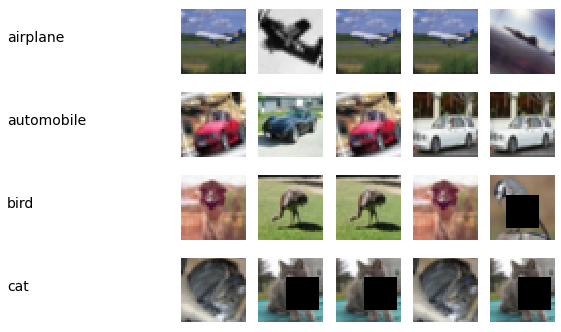

In [ ]:
from __future__ import print_function
# channel_means = (0.49196659, 0.48229005, 0.4461573)
# channel_stdevs = (0.24703223, 0.24348513, 0.26158784)
def unnormalize(img):
  img = img.numpy().astype(dtype=np.float32)
  
  for i in range(img.shape[0]):
    img[i] = (img[i]*sdev[i])+mean[i]
  
  return np.transpose(img, (1,2,0))

%matplotlib inline
import matplotlib.pyplot as plt
dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

num_classes = 10
# display 10 images from each category. 
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
r, c = 10, 11
n = 5
fig = plt.figure(figsize=(15,15))
fig.subplots_adjust(hspace=0.2, wspace=0.2)
for i in range(num_classes):
    idx = np.random.choice(np.where(labels[:]==i)[0], n)
    ax = plt.subplot(r, c, i*c+1)
    ax.text(-1.5, 0.5, class_names[i], fontsize=14)
    plt.axis('off')
    for j in range(1, n+1):
      plt.subplot(r, c, i*c+j+1)
      plt.imshow(unnormalize(images[idx[j-1]]), interpolation='none')
      plt.axis('off')
plt.show()

# Code 9: 

In [ ]:
# class Net9(nn.Module):
#     def __init__(self):
#         super().__init__()

#         self.block1 = nn.Sequential(
#             cv(3, 16, 3, padding=1),
#             relu(),
#             bn(16),
#             cv(16, 32, 3, dilation=2, groups=8, padding=1),
#             relu(),
#             bn(32),
#             nn.Dropout2d(0.07)
           
#         )

#         self.block2 = nn.Sequential(
#             cv(32, 64, 3, padding=1, dilation=1, groups=8),
#             relu(),
#             bn(64),
#             cv(64, 80, 3, dilation=1, padding=0, groups=4),
#             relu(),
#             bn(80),
#             cv(80, 64, 1),
#             relu(),
#             bn(64),
#             cv(64, 64, 3, padding=1, dilation=2),
#             relu(),
#             bn(64),
#             nn.Dropout2d(0.09)
#             # Conv2d(32, 32, 3, padding=2, dilation=2, stride=2)
#         )

#         self.block3a = nn.Sequential(
#             cv(64, 128, 3, dilation=1, groups=32, stride=1),
#             relu(),
#             bn(128),
#             cv(128, 160, 3, groups=16, dilation=1, padding=1),
#             relu(),
#             bn(160))
        
#         self.block3b = nn.Sequential(
#             cv(160, 64, 1),
#             cv(64, 64, 3, padding=1, groups=16),
#             relu(),
#             bn(64),
#             cv(64, 96, 3, padding=2, dilation=2, stride=2),
#             relu(),
#             bn(96),
#             nn.Dropout2d(0.09)
#         )

#         self.block4 = nn.Sequential(
#             cv(96, 224, 3, padding=1, groups=16, stride=1, dilation=2), # grps 32 changed to 64
#             bn(224),
#             cv(224, 64, 1),
#             bn(64),
#             relu(),
#             nn.Dropout2d(0.05),
#             cv(64, 64, 3, groups=64, padding=1), # depthwise (a)
#             cv(64, 32, 1), # pointwise for preceding depthwise (b)
#             bn(32),
#             relu(),
#             cv(32, 32, 3, dilation=1, groups=16),
#             relu(),
#             bn(32),
#             cv(32, 10, 1),
#             nn.AdaptiveAvgPool2d(1)
#             # cv(10, 10, 1)
#         )
    
        
#     def forward(self, x):
#         x = self.block1(x)
#         x = self.block2(x)
#         x = self.block3a(x)
#         x = self.block3b(x)
#         x = self.block4(x)
        
#         x = x.view(-1, 10)
#         return F.log_softmax(x, dim=-1)


# model = Net9().to(device)
# summary(model, (3, 32, 32))

In [ ]:
# optimizer = optim.SGD(model.parameters(), lr=0.0159, momentum=0.9, nesterov=True) # lr changed
# step_lr = StepLR(optimizer=optimizer, step_size=2, gamma=0.71) # gamma changed from previous value

# train_losses = []
# train_accuracy = []
# test_losses = []
# test_accuracy = []

# train_eval_model(model, train_loader, optimizer, device, epochs=100, test=True, test_loader=test_loader,scheduler=step_lr)

In [ ]:
# plot_graphs(train_losses=train_losses, train_accuracy=train_accuracy,
#             test_losses=test_losses,test_accuracy=test_accuracy)

# Code 11

In [ ]:
class Net11(nn.Module):
    def __init__(self):
        super().__init__()

        self.block1 = nn.Sequential(
            cv(3, 16, 3, padding=1),
            relu(),
            bn(16),
            cv(16, 16, 1),
            relu(),
            bn(16),
            cv(16, 32, 3, dilation=1, groups=1, padding=1),
            relu(),
            bn(32),
            cv(32, 32, 1),
            relu(),
            bn(32),
            nn.Dropout2d(0.05)
        )

        self.block2 = nn.Sequential(
            cv(32, 64, 3, padding=1, dilation=1, groups=32),
            relu(),
            bn(64),
            cv(64, 32, 1),
            relu(),
            bn(32),
            cv(32, 64, 3, dilation=1, padding=1, groups=16),
            relu(),
            bn(64),
            cv(64, 48, 1),
            relu(),
            bn(48),
            cv(48, 64, 3, padding=1, dilation=2, groups=8),
            relu(),
            bn(64),
            cv(64, 32, 1),
            relu(),
            bn(32),
            nn.Dropout2d(0.08)
        )

        self.block3 = nn.Sequential(
            cv(32, 64, 3, dilation=1, padding=1, groups=32, stride=1),
            relu(),
            bn(64),
            cv(64, 128, 3, groups=16, dilation=1, padding=1),
            relu(),
            bn(128),
            cv(128, 64, 1),
            relu(),
            bn(64),
            cv(64, 96, 3, padding=1, groups=32),
            relu(),
            bn(96),
            cv(96, 64, 1),
            relu(),
            bn(64),
            cv(64, 64, 3, padding=2, dilation=2, stride=2),
            relu(),
            bn(64),
            cv(64, 64, 1),
            relu(),
            bn(64),
            nn.Dropout2d(0.09)
            )

        self.block4 = nn.Sequential(
            cv(64, 96, 3, padding=0, groups=32, stride=1, dilation=2),
            bn(96),
            relu(),
            cv(96, 64, 1),
            bn(64),
            relu(),
            nn.Dropout2d(0.05),
            cv(64, 64, 3, groups=64, padding=0, dilation=2), # depthwise (a)
            cv(64, 32, 1), # pointwise for preceding depthwise (b)
            bn(32),
            relu(),
            cv(32, 48, 3, dilation=2, groups=8),
            relu(),
            bn(48),
            cv(48, 10, 1, stride=1),
            relu(),
            bn(10),
            nn.AdaptiveAvgPool2d(1)
            # cv(10, 10, 1)
        )
    
        
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)


model = Net11().to(device)
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
              ReLU-2           [-1, 16, 32, 32]               0
       BatchNorm2d-3           [-1, 16, 32, 32]              32
            Conv2d-4           [-1, 16, 32, 32]             256
              ReLU-5           [-1, 16, 32, 32]               0
       BatchNorm2d-6           [-1, 16, 32, 32]              32
            Conv2d-7           [-1, 32, 32, 32]           4,608
              ReLU-8           [-1, 32, 32, 32]               0
       BatchNorm2d-9           [-1, 32, 32, 32]              64
           Conv2d-10           [-1, 32, 32, 32]           1,024
             ReLU-11           [-1, 32, 32, 32]               0
      BatchNorm2d-12           [-1, 32, 32, 32]              64
        Dropout2d-13           [-1, 32, 32, 32]               0
           Conv2d-14           [-1, 64,

In [ ]:
# optimizer = optim.SGD(model.parameters(), lr=0.00001, momentum=0.9, nesterov=True) #0.097, 0.13 works with gamma=0.71 and batch=64 withoit nan loss
# step_lr = StepLR(optimizer=optimizer, step_size=1, gamma=0.87)

optimizer = optim.Adam(model.parameters(), lr=0.0001)

train_losses = []
train_accuracy = []
test_losses = []
test_accuracy = []

train_eval_model(model, train_loader, optimizer, device, epochs=30, test=True, test_loader=test_loader,scheduler=None)
torch.save(model, "./s7_exp_3.pth")

  0%|          | 0/1563 [00:00<?, ?it/s]


 epoch num ================================= 1


100%|██████████| 1563/1563 [01:21<00:00, 19.15it/s]


			Train metrics: accuracy: 7469/50000 (14.9380%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 2.1200, accuracy: 2146/10000 (21.46000%)


 epoch num ================================= 2


100%|██████████| 1563/1563 [01:18<00:00, 19.87it/s]


			Train metrics: accuracy: 15041/50000 (30.0820%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 1.6759, accuracy: 3888/10000 (38.88000%)


 epoch num ================================= 3


100%|██████████| 1563/1563 [01:18<00:00, 19.85it/s]


			Train metrics: accuracy: 19124/50000 (38.2480%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 1.5523, accuracy: 4306/10000 (43.06000%)


 epoch num ================================= 4


100%|██████████| 1563/1563 [01:18<00:00, 19.79it/s]


			Train metrics: accuracy: 21369/50000 (42.7380%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 1.4712, accuracy: 4621/10000 (46.21000%)


 epoch num ================================= 5


100%|██████████| 1563/1563 [01:18<00:00, 19.89it/s]


			Train metrics: accuracy: 22919/50000 (45.8380%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 1.3800, accuracy: 5031/10000 (50.31000%)


 epoch num ================================= 6


100%|██████████| 1563/1563 [01:18<00:00, 19.89it/s]


			Train metrics: accuracy: 24108/50000 (48.2160%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 1.3038, accuracy: 5311/10000 (53.11000%)


 epoch num ================================= 7


100%|██████████| 1563/1563 [01:18<00:00, 19.85it/s]


			Train metrics: accuracy: 25117/50000 (50.2340%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 1.2643, accuracy: 5504/10000 (55.04000%)


 epoch num ================================= 8


100%|██████████| 1563/1563 [01:19<00:00, 19.78it/s]


			Train metrics: accuracy: 26291/50000 (52.5820%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 1.2302, accuracy: 5593/10000 (55.93000%)


 epoch num ================================= 9


100%|██████████| 1563/1563 [01:18<00:00, 19.84it/s]


			Train metrics: accuracy: 27007/50000 (54.0140%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 1.1821, accuracy: 5771/10000 (57.71000%)


 epoch num ================================= 10


100%|██████████| 1563/1563 [01:18<00:00, 19.82it/s]


			Train metrics: accuracy: 27850/50000 (55.7000%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 1.1513, accuracy: 5833/10000 (58.33000%)


 epoch num ================================= 11


100%|██████████| 1563/1563 [01:18<00:00, 19.90it/s]


			Train metrics: accuracy: 28465/50000 (56.9300%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 1.1329, accuracy: 5937/10000 (59.37000%)


 epoch num ================================= 12


100%|██████████| 1563/1563 [01:17<00:00, 20.27it/s]


			Train metrics: accuracy: 29160/50000 (58.3200%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 1.0976, accuracy: 6090/10000 (60.90000%)


 epoch num ================================= 13


100%|██████████| 1563/1563 [01:17<00:00, 20.22it/s]


			Train metrics: accuracy: 29782/50000 (59.5640%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 1.0681, accuracy: 6213/10000 (62.13000%)


 epoch num ================================= 14


100%|██████████| 1563/1563 [01:17<00:00, 20.28it/s]


			Train metrics: accuracy: 30254/50000 (60.5080%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 1.0492, accuracy: 6261/10000 (62.61000%)


 epoch num ================================= 15


100%|██████████| 1563/1563 [01:17<00:00, 20.27it/s]


			Train metrics: accuracy: 30693/50000 (61.3860%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 1.0400, accuracy: 6376/10000 (63.76000%)


 epoch num ================================= 16


100%|██████████| 1563/1563 [01:17<00:00, 20.24it/s]


			Train metrics: accuracy: 31146/50000 (62.2920%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.9863, accuracy: 6525/10000 (65.25000%)


 epoch num ================================= 17


100%|██████████| 1563/1563 [01:17<00:00, 20.20it/s]


			Train metrics: accuracy: 31579/50000 (63.1580%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.9640, accuracy: 6566/10000 (65.66000%)


 epoch num ================================= 18


100%|██████████| 1563/1563 [01:17<00:00, 20.20it/s]


			Train metrics: accuracy: 31964/50000 (63.9280%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.9385, accuracy: 6674/10000 (66.74000%)


 epoch num ================================= 19


100%|██████████| 1563/1563 [01:17<00:00, 20.18it/s]


			Train metrics: accuracy: 32305/50000 (64.6100%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.9404, accuracy: 6695/10000 (66.95000%)


 epoch num ================================= 20


100%|██████████| 1563/1563 [01:17<00:00, 20.16it/s]


			Train metrics: accuracy: 32789/50000 (65.5780%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.9118, accuracy: 6784/10000 (67.84000%)


 epoch num ================================= 21


100%|██████████| 1563/1563 [01:17<00:00, 20.21it/s]


			Train metrics: accuracy: 32983/50000 (65.9660%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.9015, accuracy: 6829/10000 (68.29000%)


 epoch num ================================= 22


100%|██████████| 1563/1563 [01:17<00:00, 20.10it/s]


			Train metrics: accuracy: 33382/50000 (66.7640%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.9139, accuracy: 6800/10000 (68.00000%)


 epoch num ================================= 23


100%|██████████| 1563/1563 [01:17<00:00, 20.15it/s]


			Train metrics: accuracy: 33759/50000 (67.5180%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.8784, accuracy: 6883/10000 (68.83000%)


 epoch num ================================= 24


100%|██████████| 1563/1563 [01:17<00:00, 20.14it/s]


			Train metrics: accuracy: 34016/50000 (68.0320%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.8690, accuracy: 6923/10000 (69.23000%)


 epoch num ================================= 25


100%|██████████| 1563/1563 [01:17<00:00, 20.21it/s]


			Train metrics: accuracy: 34194/50000 (68.3880%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.8900, accuracy: 6890/10000 (68.90000%)


 epoch num ================================= 26


100%|██████████| 1563/1563 [01:17<00:00, 20.09it/s]


			Train metrics: accuracy: 34442/50000 (68.8840%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.8407, accuracy: 7036/10000 (70.36000%)


 epoch num ================================= 27


100%|██████████| 1563/1563 [01:17<00:00, 20.15it/s]


			Train metrics: accuracy: 34760/50000 (69.5200%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.8639, accuracy: 6955/10000 (69.55000%)


 epoch num ================================= 28


100%|██████████| 1563/1563 [01:17<00:00, 20.14it/s]


			Train metrics: accuracy: 35066/50000 (70.1320%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.8289, accuracy: 7095/10000 (70.95000%)


 epoch num ================================= 29


100%|██████████| 1563/1563 [01:17<00:00, 20.15it/s]


			Train metrics: accuracy: 35248/50000 (70.4960%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.8147, accuracy: 7129/10000 (71.29000%)


 epoch num ================================= 30


100%|██████████| 1563/1563 [01:17<00:00, 20.11it/s]


			Train metrics: accuracy: 35541/50000 (71.0820%)



	Test metrics: average loss: 0.8143, accuracy: 7170/10000 (71.70000%)



In [ ]:
# optimizer = optim.SGD(model.parameters(), lr=0.0005, momentum=0.9, nesterov=True) #0.097, 0.13 works with gamma=0.71 and batch=64 withoit nan loss
# step_lr = StepLR(optimizer=optimizer, step_size=1, gamma=0.81)

optimizer = optim.Adam(model.parameters(), lr=0.001)

train_eval_model(model, train_loader, optimizer, device, epochs=25, test=True, test_loader=test_loader,scheduler=None)
torch.save(model, "./s7_exp_3.pth")

  0%|          | 0/1563 [00:00<?, ?it/s]


 epoch num ================================= 1


100%|██████████| 1563/1563 [01:19<00:00, 19.73it/s]


			Train metrics: accuracy: 26435/50000 (52.8700%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.9810, accuracy: 6668/10000 (66.68000%)


 epoch num ================================= 2


100%|██████████| 1563/1563 [01:16<00:00, 20.34it/s]


			Train metrics: accuracy: 31074/50000 (62.1480%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.8580, accuracy: 6977/10000 (69.77000%)


 epoch num ================================= 3


100%|██████████| 1563/1563 [01:17<00:00, 20.19it/s]


			Train metrics: accuracy: 32897/50000 (65.7940%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.9132, accuracy: 6893/10000 (68.93000%)


 epoch num ================================= 4


100%|██████████| 1563/1563 [01:16<00:00, 20.32it/s]


			Train metrics: accuracy: 33745/50000 (67.4900%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.8089, accuracy: 7154/10000 (71.54000%)


 epoch num ================================= 5


100%|██████████| 1563/1563 [01:16<00:00, 20.32it/s]


			Train metrics: accuracy: 34458/50000 (68.9160%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.7738, accuracy: 7260/10000 (72.60000%)


 epoch num ================================= 6


100%|██████████| 1563/1563 [01:16<00:00, 20.31it/s]


			Train metrics: accuracy: 34874/50000 (69.7480%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.8190, accuracy: 7188/10000 (71.88000%)


 epoch num ================================= 7


100%|██████████| 1563/1563 [01:16<00:00, 20.35it/s]


			Train metrics: accuracy: 35334/50000 (70.6680%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.7383, accuracy: 7470/10000 (74.70000%)


 epoch num ================================= 8


100%|██████████| 1563/1563 [01:17<00:00, 20.28it/s]


			Train metrics: accuracy: 35816/50000 (71.6320%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.7586, accuracy: 7350/10000 (73.50000%)


 epoch num ================================= 9


100%|██████████| 1563/1563 [01:16<00:00, 20.32it/s]


			Train metrics: accuracy: 36100/50000 (72.2000%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.6717, accuracy: 7703/10000 (77.03000%)


 epoch num ================================= 10


100%|██████████| 1563/1563 [01:16<00:00, 20.31it/s]


			Train metrics: accuracy: 36425/50000 (72.8500%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.6446, accuracy: 7765/10000 (77.65000%)


 epoch num ================================= 11


100%|██████████| 1563/1563 [01:16<00:00, 20.32it/s]


			Train metrics: accuracy: 36578/50000 (73.1560%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.6885, accuracy: 7636/10000 (76.36000%)


 epoch num ================================= 12


100%|██████████| 1563/1563 [01:17<00:00, 20.29it/s]


			Train metrics: accuracy: 36943/50000 (73.8860%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.6754, accuracy: 7683/10000 (76.83000%)


 epoch num ================================= 13


100%|██████████| 1563/1563 [01:17<00:00, 20.19it/s]


			Train metrics: accuracy: 37370/50000 (74.7400%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.6707, accuracy: 7716/10000 (77.16000%)


 epoch num ================================= 14


100%|██████████| 1563/1563 [01:17<00:00, 20.29it/s]


			Train metrics: accuracy: 37385/50000 (74.7700%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.6438, accuracy: 7812/10000 (78.12000%)


 epoch num ================================= 15


100%|██████████| 1563/1563 [01:17<00:00, 20.22it/s]


			Train metrics: accuracy: 37620/50000 (75.2400%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.6307, accuracy: 7823/10000 (78.23000%)


 epoch num ================================= 16


100%|██████████| 1563/1563 [01:17<00:00, 20.24it/s]


			Train metrics: accuracy: 37791/50000 (75.5820%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.6208, accuracy: 7895/10000 (78.95000%)


 epoch num ================================= 17


100%|██████████| 1563/1563 [01:17<00:00, 20.24it/s]


			Train metrics: accuracy: 37862/50000 (75.7240%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.6444, accuracy: 7787/10000 (77.87000%)


 epoch num ================================= 18


100%|██████████| 1563/1563 [01:17<00:00, 20.22it/s]


			Train metrics: accuracy: 38293/50000 (76.5860%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.6406, accuracy: 7866/10000 (78.66000%)


 epoch num ================================= 19


100%|██████████| 1563/1563 [01:18<00:00, 19.97it/s]


			Train metrics: accuracy: 38380/50000 (76.7600%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.6103, accuracy: 7923/10000 (79.23000%)


 epoch num ================================= 20


100%|██████████| 1563/1563 [01:19<00:00, 19.74it/s]



			Train metrics: accuracy: 38576/50000 (77.1520%)


  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.6111, accuracy: 7902/10000 (79.02000%)


 epoch num ================================= 21


100%|██████████| 1563/1563 [01:18<00:00, 19.79it/s]


			Train metrics: accuracy: 38744/50000 (77.4880%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.6017, accuracy: 7955/10000 (79.55000%)


 epoch num ================================= 22


100%|██████████| 1563/1563 [01:18<00:00, 19.80it/s]


			Train metrics: accuracy: 38821/50000 (77.6420%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.6148, accuracy: 7894/10000 (78.94000%)


 epoch num ================================= 23


100%|██████████| 1563/1563 [01:17<00:00, 20.08it/s]



			Train metrics: accuracy: 39091/50000 (78.1820%)


  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.5948, accuracy: 8004/10000 (80.04000%)


 epoch num ================================= 24


100%|██████████| 1563/1563 [01:18<00:00, 20.03it/s]


			Train metrics: accuracy: 38977/50000 (77.9540%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.5750, accuracy: 8036/10000 (80.36000%)


 epoch num ================================= 25


100%|██████████| 1563/1563 [01:18<00:00, 20.02it/s]


			Train metrics: accuracy: 39367/50000 (78.7340%)



	Test metrics: average loss: 0.5871, accuracy: 8012/10000 (80.12000%)



In [ ]:
# optimizer = optim.SGD(model.parameters(), lr=0.0005, momentum=0.9, nesterov=True) #0.097, 0.13 works with gamma=0.71 and batch=64 withoit nan loss
# step_lr = StepLR(optimizer=optimizer, step_size=1, gamma=0.81)
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_eval_model(model, train_loader, optimizer, device, epochs=100, test=True, test_loader=test_loader,scheduler=None)
torch.save(model, "./s7_exp_3.pth")

  0%|          | 0/1563 [00:00<?, ?it/s]


 epoch num ================================= 1


100%|██████████| 1563/1563 [01:20<00:00, 19.45it/s]



			Train metrics: accuracy: 34869/50000 (69.7380%)


  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.5979, accuracy: 8084/10000 (80.84000%)


 epoch num ================================= 2


100%|██████████| 1563/1563 [01:16<00:00, 20.31it/s]


			Train metrics: accuracy: 38968/50000 (77.9360%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.5507, accuracy: 8131/10000 (81.31000%)


 epoch num ================================= 3


100%|██████████| 1563/1563 [01:16<00:00, 20.37it/s]


			Train metrics: accuracy: 39745/50000 (79.4900%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.5157, accuracy: 8270/10000 (82.70000%)


 epoch num ================================= 4


100%|██████████| 1563/1563 [01:17<00:00, 20.20it/s]


			Train metrics: accuracy: 40157/50000 (80.3140%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.5324, accuracy: 8168/10000 (81.68000%)


 epoch num ================================= 5


100%|██████████| 1563/1563 [01:18<00:00, 19.95it/s]


			Train metrics: accuracy: 40343/50000 (80.6860%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.5414, accuracy: 8167/10000 (81.67000%)


 epoch num ================================= 6


100%|██████████| 1563/1563 [01:17<00:00, 20.19it/s]


			Train metrics: accuracy: 40351/50000 (80.7020%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.5166, accuracy: 8236/10000 (82.36000%)


 epoch num ================================= 7


100%|██████████| 1563/1563 [01:17<00:00, 20.20it/s]



			Train metrics: accuracy: 40550/50000 (81.1000%)


  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.5590, accuracy: 8116/10000 (81.16000%)


 epoch num ================================= 8


100%|██████████| 1563/1563 [01:17<00:00, 20.11it/s]


			Train metrics: accuracy: 40545/50000 (81.0900%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.5801, accuracy: 8037/10000 (80.37000%)


 epoch num ================================= 9


100%|██████████| 1563/1563 [01:19<00:00, 19.68it/s]


			Train metrics: accuracy: 40813/50000 (81.6260%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4999, accuracy: 8269/10000 (82.69000%)


 epoch num ================================= 10


100%|██████████| 1563/1563 [01:18<00:00, 19.83it/s]


			Train metrics: accuracy: 40846/50000 (81.6920%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4944, accuracy: 8354/10000 (83.54000%)


 epoch num ================================= 11


100%|██████████| 1563/1563 [01:18<00:00, 19.79it/s]


			Train metrics: accuracy: 40970/50000 (81.9400%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.5057, accuracy: 8305/10000 (83.05000%)


 epoch num ================================= 12


100%|██████████| 1563/1563 [01:18<00:00, 19.82it/s]


			Train metrics: accuracy: 41157/50000 (82.3140%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.5100, accuracy: 8268/10000 (82.68000%)


 epoch num ================================= 13


100%|██████████| 1563/1563 [01:18<00:00, 19.81it/s]


			Train metrics: accuracy: 41090/50000 (82.1800%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4803, accuracy: 8386/10000 (83.86000%)


 epoch num ================================= 14


100%|██████████| 1563/1563 [01:19<00:00, 19.77it/s]


			Train metrics: accuracy: 41163/50000 (82.3260%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.5066, accuracy: 8285/10000 (82.85000%)


 epoch num ================================= 15


100%|██████████| 1563/1563 [01:18<00:00, 19.80it/s]



			Train metrics: accuracy: 41292/50000 (82.5840%)


  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4939, accuracy: 8362/10000 (83.62000%)


 epoch num ================================= 16


100%|██████████| 1563/1563 [01:19<00:00, 19.78it/s]


			Train metrics: accuracy: 41266/50000 (82.5320%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.5195, accuracy: 8289/10000 (82.89000%)


 epoch num ================================= 17


100%|██████████| 1563/1563 [01:19<00:00, 19.77it/s]


			Train metrics: accuracy: 41425/50000 (82.8500%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.5057, accuracy: 8305/10000 (83.05000%)


 epoch num ================================= 18


100%|██████████| 1563/1563 [01:19<00:00, 19.74it/s]


			Train metrics: accuracy: 41476/50000 (82.9520%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4867, accuracy: 8347/10000 (83.47000%)


 epoch num ================================= 19


100%|██████████| 1563/1563 [01:18<00:00, 19.80it/s]


			Train metrics: accuracy: 41567/50000 (83.1340%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.5140, accuracy: 8318/10000 (83.18000%)


 epoch num ================================= 20


100%|██████████| 1563/1563 [01:19<00:00, 19.75it/s]


			Train metrics: accuracy: 41725/50000 (83.4500%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.5290, accuracy: 8279/10000 (82.79000%)


 epoch num ================================= 21


100%|██████████| 1563/1563 [01:19<00:00, 19.76it/s]


			Train metrics: accuracy: 41628/50000 (83.2560%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4864, accuracy: 8396/10000 (83.96000%)


 epoch num ================================= 22


100%|██████████| 1563/1563 [01:19<00:00, 19.61it/s]


			Train metrics: accuracy: 41584/50000 (83.1680%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4789, accuracy: 8391/10000 (83.91000%)


 epoch num ================================= 23


100%|██████████| 1563/1563 [01:19<00:00, 19.68it/s]


			Train metrics: accuracy: 41670/50000 (83.3400%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4752, accuracy: 8388/10000 (83.88000%)


 epoch num ================================= 24


100%|██████████| 1563/1563 [01:19<00:00, 19.64it/s]


			Train metrics: accuracy: 41914/50000 (83.8280%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4731, accuracy: 8414/10000 (84.14000%)


 epoch num ================================= 25


100%|██████████| 1563/1563 [01:19<00:00, 19.62it/s]


			Train metrics: accuracy: 41763/50000 (83.5260%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.5034, accuracy: 8333/10000 (83.33000%)


 epoch num ================================= 26


100%|██████████| 1563/1563 [01:19<00:00, 19.58it/s]


			Train metrics: accuracy: 41856/50000 (83.7120%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4660, accuracy: 8462/10000 (84.62000%)


 epoch num ================================= 27


100%|██████████| 1563/1563 [01:19<00:00, 19.59it/s]


			Train metrics: accuracy: 41961/50000 (83.9220%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.5014, accuracy: 8351/10000 (83.51000%)


 epoch num ================================= 28


100%|██████████| 1563/1563 [01:19<00:00, 19.60it/s]


			Train metrics: accuracy: 42119/50000 (84.2380%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4725, accuracy: 8431/10000 (84.31000%)


 epoch num ================================= 29


100%|██████████| 1563/1563 [01:19<00:00, 19.57it/s]


			Train metrics: accuracy: 41996/50000 (83.9920%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4757, accuracy: 8408/10000 (84.08000%)


 epoch num ================================= 30


100%|██████████| 1563/1563 [01:19<00:00, 19.55it/s]


			Train metrics: accuracy: 42243/50000 (84.4860%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4702, accuracy: 8446/10000 (84.46000%)


 epoch num ================================= 31


100%|██████████| 1563/1563 [01:20<00:00, 19.51it/s]


			Train metrics: accuracy: 42090/50000 (84.1800%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.5075, accuracy: 8354/10000 (83.54000%)


 epoch num ================================= 32


100%|██████████| 1563/1563 [01:20<00:00, 19.53it/s]


			Train metrics: accuracy: 42154/50000 (84.3080%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4876, accuracy: 8393/10000 (83.93000%)


 epoch num ================================= 33


100%|██████████| 1563/1563 [01:19<00:00, 19.54it/s]


			Train metrics: accuracy: 42186/50000 (84.3720%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4705, accuracy: 8451/10000 (84.51000%)


 epoch num ================================= 34


100%|██████████| 1563/1563 [01:20<00:00, 19.52it/s]


			Train metrics: accuracy: 42165/50000 (84.3300%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4807, accuracy: 8390/10000 (83.90000%)


 epoch num ================================= 35


100%|██████████| 1563/1563 [01:20<00:00, 19.52it/s]


			Train metrics: accuracy: 42321/50000 (84.6420%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4856, accuracy: 8417/10000 (84.17000%)


 epoch num ================================= 36


100%|██████████| 1563/1563 [01:20<00:00, 19.51it/s]


			Train metrics: accuracy: 42468/50000 (84.9360%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4821, accuracy: 8394/10000 (83.94000%)


 epoch num ================================= 37


100%|██████████| 1563/1563 [01:20<00:00, 19.51it/s]


			Train metrics: accuracy: 42320/50000 (84.6400%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4432, accuracy: 8474/10000 (84.74000%)


 epoch num ================================= 38


100%|██████████| 1563/1563 [01:20<00:00, 19.47it/s]


			Train metrics: accuracy: 42385/50000 (84.7700%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4520, accuracy: 8473/10000 (84.73000%)


 epoch num ================================= 39


100%|██████████| 1563/1563 [01:19<00:00, 19.55it/s]


			Train metrics: accuracy: 42394/50000 (84.7880%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4609, accuracy: 8469/10000 (84.69000%)


 epoch num ================================= 40


100%|██████████| 1563/1563 [01:20<00:00, 19.53it/s]


			Train metrics: accuracy: 42400/50000 (84.8000%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4721, accuracy: 8445/10000 (84.45000%)


 epoch num ================================= 41


100%|██████████| 1563/1563 [01:20<00:00, 19.51it/s]


			Train metrics: accuracy: 42448/50000 (84.8960%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4489, accuracy: 8457/10000 (84.57000%)


 epoch num ================================= 42


100%|██████████| 1563/1563 [01:20<00:00, 19.47it/s]


			Train metrics: accuracy: 42525/50000 (85.0500%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4709, accuracy: 8415/10000 (84.15000%)


 epoch num ================================= 43


100%|██████████| 1563/1563 [01:20<00:00, 19.49it/s]


			Train metrics: accuracy: 42657/50000 (85.3140%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4594, accuracy: 8482/10000 (84.82000%)


 epoch num ================================= 44


100%|██████████| 1563/1563 [01:21<00:00, 19.27it/s]


			Train metrics: accuracy: 42721/50000 (85.4420%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4719, accuracy: 8424/10000 (84.24000%)


 epoch num ================================= 45


100%|██████████| 1563/1563 [01:20<00:00, 19.50it/s]


			Train metrics: accuracy: 42761/50000 (85.5220%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4717, accuracy: 8433/10000 (84.33000%)


 epoch num ================================= 46


100%|██████████| 1563/1563 [01:20<00:00, 19.49it/s]


			Train metrics: accuracy: 42807/50000 (85.6140%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4520, accuracy: 8512/10000 (85.12000%)


 epoch num ================================= 47


100%|██████████| 1563/1563 [01:20<00:00, 19.52it/s]


			Train metrics: accuracy: 42788/50000 (85.5760%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4556, accuracy: 8487/10000 (84.87000%)


 epoch num ================================= 48


100%|██████████| 1563/1563 [01:20<00:00, 19.45it/s]


			Train metrics: accuracy: 42794/50000 (85.5880%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4526, accuracy: 8488/10000 (84.88000%)


 epoch num ================================= 49


100%|██████████| 1563/1563 [01:19<00:00, 19.56it/s]


			Train metrics: accuracy: 42807/50000 (85.6140%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4469, accuracy: 8507/10000 (85.07000%)


 epoch num ================================= 50


100%|██████████| 1563/1563 [01:20<00:00, 19.47it/s]


			Train metrics: accuracy: 42898/50000 (85.7960%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4808, accuracy: 8429/10000 (84.29000%)


 epoch num ================================= 51


100%|██████████| 1563/1563 [01:20<00:00, 19.46it/s]


			Train metrics: accuracy: 42862/50000 (85.7240%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4531, accuracy: 8490/10000 (84.90000%)


 epoch num ================================= 52


100%|██████████| 1563/1563 [01:20<00:00, 19.45it/s]


			Train metrics: accuracy: 42995/50000 (85.9900%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4473, accuracy: 8552/10000 (85.52000%)


 epoch num ================================= 53


100%|██████████| 1563/1563 [01:20<00:00, 19.46it/s]


			Train metrics: accuracy: 43043/50000 (86.0860%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4659, accuracy: 8478/10000 (84.78000%)


 epoch num ================================= 54


100%|██████████| 1563/1563 [01:20<00:00, 19.48it/s]


			Train metrics: accuracy: 43069/50000 (86.1380%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4665, accuracy: 8464/10000 (84.64000%)


 epoch num ================================= 55


100%|██████████| 1563/1563 [01:20<00:00, 19.50it/s]


			Train metrics: accuracy: 42976/50000 (85.9520%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4595, accuracy: 8507/10000 (85.07000%)


 epoch num ================================= 56


100%|██████████| 1563/1563 [01:20<00:00, 19.49it/s]


			Train metrics: accuracy: 43224/50000 (86.4480%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4502, accuracy: 8481/10000 (84.81000%)


 epoch num ================================= 57


100%|██████████| 1563/1563 [01:20<00:00, 19.49it/s]


			Train metrics: accuracy: 43047/50000 (86.0940%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4608, accuracy: 8437/10000 (84.37000%)


 epoch num ================================= 58


100%|██████████| 1563/1563 [01:20<00:00, 19.46it/s]


			Train metrics: accuracy: 43181/50000 (86.3620%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4348, accuracy: 8567/10000 (85.67000%)


 epoch num ================================= 59


100%|██████████| 1563/1563 [01:20<00:00, 19.45it/s]


			Train metrics: accuracy: 43089/50000 (86.1780%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4624, accuracy: 8465/10000 (84.65000%)


 epoch num ================================= 60


100%|██████████| 1563/1563 [01:20<00:00, 19.45it/s]


			Train metrics: accuracy: 43207/50000 (86.4140%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4540, accuracy: 8479/10000 (84.79000%)


 epoch num ================================= 61


100%|██████████| 1563/1563 [01:20<00:00, 19.47it/s]


			Train metrics: accuracy: 43091/50000 (86.1820%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4472, accuracy: 8499/10000 (84.99000%)


 epoch num ================================= 62


100%|██████████| 1563/1563 [01:20<00:00, 19.44it/s]


			Train metrics: accuracy: 43292/50000 (86.5840%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4763, accuracy: 8446/10000 (84.46000%)


 epoch num ================================= 63


100%|██████████| 1563/1563 [01:20<00:00, 19.45it/s]


			Train metrics: accuracy: 43224/50000 (86.4480%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4551, accuracy: 8540/10000 (85.40000%)


 epoch num ================================= 64


100%|██████████| 1563/1563 [01:20<00:00, 19.43it/s]


			Train metrics: accuracy: 43307/50000 (86.6140%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4930, accuracy: 8388/10000 (83.88000%)


 epoch num ================================= 65


100%|██████████| 1563/1563 [01:20<00:00, 19.45it/s]


			Train metrics: accuracy: 43193/50000 (86.3860%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4270, accuracy: 8577/10000 (85.77000%)


 epoch num ================================= 66


100%|██████████| 1563/1563 [01:20<00:00, 19.47it/s]


			Train metrics: accuracy: 43348/50000 (86.6960%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4515, accuracy: 8537/10000 (85.37000%)


 epoch num ================================= 67


100%|██████████| 1563/1563 [01:20<00:00, 19.41it/s]


			Train metrics: accuracy: 43429/50000 (86.8580%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4429, accuracy: 8574/10000 (85.74000%)


 epoch num ================================= 68


100%|██████████| 1563/1563 [01:20<00:00, 19.45it/s]


			Train metrics: accuracy: 43432/50000 (86.8640%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4486, accuracy: 8533/10000 (85.33000%)


 epoch num ================================= 69


100%|██████████| 1563/1563 [01:20<00:00, 19.46it/s]


			Train metrics: accuracy: 43493/50000 (86.9860%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4484, accuracy: 8505/10000 (85.05000%)


 epoch num ================================= 70


100%|██████████| 1563/1563 [01:20<00:00, 19.46it/s]


			Train metrics: accuracy: 43452/50000 (86.9040%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4450, accuracy: 8520/10000 (85.20000%)


 epoch num ================================= 71


100%|██████████| 1563/1563 [01:19<00:00, 19.55it/s]


			Train metrics: accuracy: 43422/50000 (86.8440%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4329, accuracy: 8552/10000 (85.52000%)


 epoch num ================================= 72


100%|██████████| 1563/1563 [01:20<00:00, 19.48it/s]


			Train metrics: accuracy: 43465/50000 (86.9300%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4804, accuracy: 8428/10000 (84.28000%)


 epoch num ================================= 73


100%|██████████| 1563/1563 [01:20<00:00, 19.39it/s]


			Train metrics: accuracy: 43553/50000 (87.1060%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4652, accuracy: 8507/10000 (85.07000%)


 epoch num ================================= 74


100%|██████████| 1563/1563 [01:20<00:00, 19.37it/s]


			Train metrics: accuracy: 43529/50000 (87.0580%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4558, accuracy: 8490/10000 (84.90000%)


 epoch num ================================= 75


100%|██████████| 1563/1563 [01:20<00:00, 19.41it/s]


			Train metrics: accuracy: 43552/50000 (87.1040%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4333, accuracy: 8553/10000 (85.53000%)


 epoch num ================================= 76


100%|██████████| 1563/1563 [01:20<00:00, 19.43it/s]


			Train metrics: accuracy: 43615/50000 (87.2300%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4431, accuracy: 8595/10000 (85.95000%)


 epoch num ================================= 77


100%|██████████| 1563/1563 [01:20<00:00, 19.44it/s]


			Train metrics: accuracy: 43609/50000 (87.2180%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4377, accuracy: 8531/10000 (85.31000%)


 epoch num ================================= 78


100%|██████████| 1563/1563 [01:20<00:00, 19.34it/s]


			Train metrics: accuracy: 43650/50000 (87.3000%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4459, accuracy: 8544/10000 (85.44000%)


 epoch num ================================= 79


100%|██████████| 1563/1563 [01:20<00:00, 19.46it/s]


			Train metrics: accuracy: 43613/50000 (87.2260%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4452, accuracy: 8522/10000 (85.22000%)


 epoch num ================================= 80


100%|██████████| 1563/1563 [01:20<00:00, 19.41it/s]


			Train metrics: accuracy: 43596/50000 (87.1920%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4155, accuracy: 8628/10000 (86.28000%)


 epoch num ================================= 81


100%|██████████| 1563/1563 [01:20<00:00, 19.36it/s]


			Train metrics: accuracy: 43679/50000 (87.3580%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4436, accuracy: 8606/10000 (86.06000%)


 epoch num ================================= 82


100%|██████████| 1563/1563 [01:21<00:00, 19.29it/s]


			Train metrics: accuracy: 43784/50000 (87.5680%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4544, accuracy: 8536/10000 (85.36000%)


 epoch num ================================= 83


100%|██████████| 1563/1563 [01:21<00:00, 19.23it/s]


			Train metrics: accuracy: 43656/50000 (87.3120%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4215, accuracy: 8587/10000 (85.87000%)


 epoch num ================================= 84


100%|██████████| 1563/1563 [01:20<00:00, 19.40it/s]


			Train metrics: accuracy: 43707/50000 (87.4140%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4305, accuracy: 8610/10000 (86.10000%)


 epoch num ================================= 85


100%|██████████| 1563/1563 [01:20<00:00, 19.43it/s]


			Train metrics: accuracy: 43883/50000 (87.7660%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4260, accuracy: 8624/10000 (86.24000%)


 epoch num ================================= 86


100%|██████████| 1563/1563 [01:20<00:00, 19.33it/s]


			Train metrics: accuracy: 43874/50000 (87.7480%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4481, accuracy: 8524/10000 (85.24000%)


 epoch num ================================= 87


100%|██████████| 1563/1563 [01:20<00:00, 19.38it/s]


			Train metrics: accuracy: 43839/50000 (87.6780%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4496, accuracy: 8533/10000 (85.33000%)


 epoch num ================================= 88


100%|██████████| 1563/1563 [01:20<00:00, 19.38it/s]


			Train metrics: accuracy: 43794/50000 (87.5880%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4426, accuracy: 8522/10000 (85.22000%)


 epoch num ================================= 89


100%|██████████| 1563/1563 [01:20<00:00, 19.43it/s]


			Train metrics: accuracy: 43875/50000 (87.7500%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4214, accuracy: 8630/10000 (86.30000%)


 epoch num ================================= 90


100%|██████████| 1563/1563 [01:20<00:00, 19.35it/s]


			Train metrics: accuracy: 44013/50000 (88.0260%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4765, accuracy: 8519/10000 (85.19000%)


 epoch num ================================= 91


100%|██████████| 1563/1563 [01:21<00:00, 19.26it/s]


			Train metrics: accuracy: 43881/50000 (87.7620%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4290, accuracy: 8575/10000 (85.75000%)


 epoch num ================================= 92


100%|██████████| 1563/1563 [01:20<00:00, 19.33it/s]


			Train metrics: accuracy: 43839/50000 (87.6780%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4263, accuracy: 8648/10000 (86.48000%)


 epoch num ================================= 93


100%|██████████| 1563/1563 [01:20<00:00, 19.36it/s]


			Train metrics: accuracy: 43955/50000 (87.9100%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4309, accuracy: 8619/10000 (86.19000%)


 epoch num ================================= 94


100%|██████████| 1563/1563 [01:20<00:00, 19.38it/s]


			Train metrics: accuracy: 43911/50000 (87.8220%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4256, accuracy: 8599/10000 (85.99000%)


 epoch num ================================= 95


100%|██████████| 1563/1563 [01:20<00:00, 19.40it/s]


			Train metrics: accuracy: 43902/50000 (87.8040%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4357, accuracy: 8552/10000 (85.52000%)


 epoch num ================================= 96


100%|██████████| 1563/1563 [01:20<00:00, 19.31it/s]


			Train metrics: accuracy: 44045/50000 (88.0900%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4274, accuracy: 8640/10000 (86.40000%)


 epoch num ================================= 97


100%|██████████| 1563/1563 [01:20<00:00, 19.39it/s]


			Train metrics: accuracy: 44000/50000 (88.0000%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4258, accuracy: 8596/10000 (85.96000%)


 epoch num ================================= 98


100%|██████████| 1563/1563 [01:20<00:00, 19.40it/s]


			Train metrics: accuracy: 44033/50000 (88.0660%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4561, accuracy: 8527/10000 (85.27000%)


 epoch num ================================= 99


100%|██████████| 1563/1563 [01:20<00:00, 19.40it/s]


			Train metrics: accuracy: 43996/50000 (87.9920%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4367, accuracy: 8620/10000 (86.20000%)


 epoch num ================================= 100


100%|██████████| 1563/1563 [01:20<00:00, 19.36it/s]


			Train metrics: accuracy: 44006/50000 (88.0120%)



	Test metrics: average loss: 0.4732, accuracy: 8559/10000 (85.59000%)



In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.0007, momentum=0.9, nesterov=True) #0.097, 0.13 works with gamma=0.71 and batch=64 withoit nan loss
# step_lr = StepLR(optimizer=optimizer, step_size=1, gamma=0.81)


train_eval_model(model, train_loader, optimizer, device, epochs=25, test=True, test_loader=test_loader,scheduler=None)

torch.save(model, "./s7_exp_3.pth")

  0%|          | 0/1563 [00:00<?, ?it/s]


 epoch num ================================= 1


100%|██████████| 1563/1563 [01:20<00:00, 19.37it/s]


			Train metrics: accuracy: 29381/50000 (58.7620%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.7113, accuracy: 7919/10000 (79.19000%)


 epoch num ================================= 2


100%|██████████| 1563/1563 [01:17<00:00, 20.07it/s]


			Train metrics: accuracy: 42050/50000 (84.1000%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4229, accuracy: 8587/10000 (85.87000%)


 epoch num ================================= 3


100%|██████████| 1563/1563 [01:17<00:00, 20.06it/s]


			Train metrics: accuracy: 43705/50000 (87.4100%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4035, accuracy: 8647/10000 (86.47000%)


 epoch num ================================= 4


100%|██████████| 1563/1563 [01:17<00:00, 20.07it/s]


			Train metrics: accuracy: 44270/50000 (88.5400%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3998, accuracy: 8686/10000 (86.86000%)


 epoch num ================================= 5


100%|██████████| 1563/1563 [01:18<00:00, 19.99it/s]


			Train metrics: accuracy: 44495/50000 (88.9900%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4013, accuracy: 8691/10000 (86.91000%)


 epoch num ================================= 6


100%|██████████| 1563/1563 [01:17<00:00, 20.06it/s]


			Train metrics: accuracy: 44906/50000 (89.8120%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4008, accuracy: 8718/10000 (87.18000%)


 epoch num ================================= 7


100%|██████████| 1563/1563 [01:17<00:00, 20.06it/s]


			Train metrics: accuracy: 45023/50000 (90.0460%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3879, accuracy: 8736/10000 (87.36000%)


 epoch num ================================= 8


100%|██████████| 1563/1563 [01:18<00:00, 19.81it/s]


			Train metrics: accuracy: 45087/50000 (90.1740%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3904, accuracy: 8745/10000 (87.45000%)


 epoch num ================================= 9


100%|██████████| 1563/1563 [01:18<00:00, 19.95it/s]


			Train metrics: accuracy: 45159/50000 (90.3180%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3792, accuracy: 8781/10000 (87.81000%)


 epoch num ================================= 10


100%|██████████| 1563/1563 [01:17<00:00, 20.24it/s]


			Train metrics: accuracy: 45287/50000 (90.5740%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3902, accuracy: 8759/10000 (87.59000%)


 epoch num ================================= 11


100%|██████████| 1563/1563 [01:16<00:00, 20.31it/s]


			Train metrics: accuracy: 45373/50000 (90.7460%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3842, accuracy: 8751/10000 (87.51000%)


 epoch num ================================= 12


100%|██████████| 1563/1563 [01:16<00:00, 20.34it/s]


			Train metrics: accuracy: 45406/50000 (90.8120%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3913, accuracy: 8781/10000 (87.81000%)


 epoch num ================================= 13


100%|██████████| 1563/1563 [01:16<00:00, 20.34it/s]


			Train metrics: accuracy: 45459/50000 (90.9180%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3881, accuracy: 8763/10000 (87.63000%)


 epoch num ================================= 14


100%|██████████| 1563/1563 [01:16<00:00, 20.39it/s]


			Train metrics: accuracy: 45513/50000 (91.0260%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3839, accuracy: 8786/10000 (87.86000%)


 epoch num ================================= 15


100%|██████████| 1563/1563 [01:16<00:00, 20.46it/s]


			Train metrics: accuracy: 45455/50000 (90.9100%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3816, accuracy: 8771/10000 (87.71000%)


 epoch num ================================= 16


100%|██████████| 1563/1563 [01:16<00:00, 20.39it/s]



			Train metrics: accuracy: 45635/50000 (91.2700%)


  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3768, accuracy: 8799/10000 (87.99000%)


 epoch num ================================= 17


100%|██████████| 1563/1563 [01:16<00:00, 20.31it/s]


			Train metrics: accuracy: 45669/50000 (91.3380%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3834, accuracy: 8788/10000 (87.88000%)


 epoch num ================================= 18


100%|██████████| 1563/1563 [01:16<00:00, 20.30it/s]


			Train metrics: accuracy: 45702/50000 (91.4040%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3860, accuracy: 8756/10000 (87.56000%)


 epoch num ================================= 19


100%|██████████| 1563/1563 [01:16<00:00, 20.31it/s]


			Train metrics: accuracy: 45572/50000 (91.1440%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3911, accuracy: 8782/10000 (87.82000%)


 epoch num ================================= 20


100%|██████████| 1563/1563 [01:17<00:00, 20.23it/s]


			Train metrics: accuracy: 45708/50000 (91.4160%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3898, accuracy: 8777/10000 (87.77000%)


 epoch num ================================= 21


100%|██████████| 1563/1563 [01:17<00:00, 20.19it/s]


			Train metrics: accuracy: 45658/50000 (91.3160%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3851, accuracy: 8786/10000 (87.86000%)


 epoch num ================================= 22


100%|██████████| 1563/1563 [01:17<00:00, 20.11it/s]


			Train metrics: accuracy: 45765/50000 (91.5300%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3851, accuracy: 8788/10000 (87.88000%)


 epoch num ================================= 23


100%|██████████| 1563/1563 [01:17<00:00, 20.09it/s]


			Train metrics: accuracy: 45794/50000 (91.5880%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3849, accuracy: 8796/10000 (87.96000%)


 epoch num ================================= 24


100%|██████████| 1563/1563 [01:17<00:00, 20.15it/s]


			Train metrics: accuracy: 45803/50000 (91.6060%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3913, accuracy: 8757/10000 (87.57000%)


 epoch num ================================= 25


100%|██████████| 1563/1563 [01:17<00:00, 20.27it/s]


			Train metrics: accuracy: 45810/50000 (91.6200%)



	Test metrics: average loss: 0.3893, accuracy: 8784/10000 (87.84000%)



In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.019, momentum=0.9, nesterov=True) #0.097, 0.13 works with gamma=0.71 and batch=64 withoit nan loss
step_lr = StepLR(optimizer=optimizer, step_size=2, gamma=0.67)


train_eval_model(model, train_loader, optimizer, device, epochs=50, test=True, test_loader=test_loader,scheduler=step_lr)

torch.save(model, "./s7_exp_3_resume_1.pth")

  0%|          | 0/1563 [00:00<?, ?it/s]


 epoch num ================================= 1


100%|██████████| 1563/1563 [01:18<00:00, 19.79it/s]



			Last LR --> [0.019]

			Train metrics: accuracy: 36510/50000 (73.0200%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4440, accuracy: 8507/10000 (85.07000%)


 epoch num ================================= 2


100%|██████████| 1563/1563 [01:16<00:00, 20.36it/s]



			Last LR --> [0.019]

			Train metrics: accuracy: 40153/50000 (80.3060%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.5212, accuracy: 8276/10000 (82.76000%)


 epoch num ================================= 3


100%|██████████| 1563/1563 [01:16<00:00, 20.34it/s]



			Last LR --> [0.01273]

			Train metrics: accuracy: 42159/50000 (84.3180%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4530, accuracy: 8506/10000 (85.06000%)


 epoch num ================================= 4


100%|██████████| 1563/1563 [01:16<00:00, 20.37it/s]



			Last LR --> [0.01273]

			Train metrics: accuracy: 42115/50000 (84.2300%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.5184, accuracy: 8294/10000 (82.94000%)


 epoch num ================================= 5


100%|██████████| 1563/1563 [01:16<00:00, 20.36it/s]



			Last LR --> [0.008529100000000001]

			Train metrics: accuracy: 43243/50000 (86.4860%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4435, accuracy: 8524/10000 (85.24000%)


 epoch num ================================= 6


100%|██████████| 1563/1563 [01:17<00:00, 20.08it/s]



			Last LR --> [0.008529100000000001]

			Train metrics: accuracy: 43536/50000 (87.0720%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4224, accuracy: 8597/10000 (85.97000%)


 epoch num ================================= 7


100%|██████████| 1563/1563 [01:16<00:00, 20.36it/s]



			Last LR --> [0.0057144970000000015]

			Train metrics: accuracy: 44189/50000 (88.3780%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4053, accuracy: 8682/10000 (86.82000%)


 epoch num ================================= 8


100%|██████████| 1563/1563 [01:16<00:00, 20.34it/s]



			Last LR --> [0.0057144970000000015]

			Train metrics: accuracy: 44294/50000 (88.5880%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4122, accuracy: 8636/10000 (86.36000%)


 epoch num ================================= 9


100%|██████████| 1563/1563 [01:16<00:00, 20.36it/s]



			Last LR --> [0.0038287129900000014]

			Train metrics: accuracy: 44987/50000 (89.9740%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3889, accuracy: 8734/10000 (87.34000%)


 epoch num ================================= 10


100%|██████████| 1563/1563 [01:16<00:00, 20.36it/s]



			Last LR --> [0.0038287129900000014]

			Train metrics: accuracy: 45019/50000 (90.0380%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4024, accuracy: 8719/10000 (87.19000%)


 epoch num ================================= 11


100%|██████████| 1563/1563 [01:16<00:00, 20.31it/s]



			Last LR --> [0.0025652377033000013]

			Train metrics: accuracy: 45433/50000 (90.8660%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3958, accuracy: 8722/10000 (87.22000%)


 epoch num ================================= 12


100%|██████████| 1563/1563 [01:17<00:00, 20.25it/s]



			Last LR --> [0.0025652377033000013]

			Train metrics: accuracy: 45441/50000 (90.8820%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3843, accuracy: 8751/10000 (87.51000%)


 epoch num ================================= 13


100%|██████████| 1563/1563 [01:17<00:00, 20.27it/s]



			Last LR --> [0.0017187092612110009]

			Train metrics: accuracy: 45666/50000 (91.3320%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4084, accuracy: 8743/10000 (87.43000%)


 epoch num ================================= 14


100%|██████████| 1563/1563 [01:18<00:00, 19.99it/s]



			Last LR --> [0.0017187092612110009]

			Train metrics: accuracy: 45554/50000 (91.1080%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3958, accuracy: 8765/10000 (87.65000%)


 epoch num ================================= 15


100%|██████████| 1563/1563 [01:18<00:00, 20.02it/s]



			Last LR --> [0.0011515352050113707]

			Train metrics: accuracy: 45735/50000 (91.4700%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3817, accuracy: 8784/10000 (87.84000%)


 epoch num ================================= 16


100%|██████████| 1563/1563 [01:18<00:00, 20.01it/s]



			Last LR --> [0.0011515352050113707]

			Train metrics: accuracy: 45917/50000 (91.8340%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3868, accuracy: 8792/10000 (87.92000%)


 epoch num ================================= 17


100%|██████████| 1563/1563 [01:18<00:00, 19.96it/s]



			Last LR --> [0.0007715285873576184]

			Train metrics: accuracy: 45955/50000 (91.9100%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3836, accuracy: 8791/10000 (87.91000%)


 epoch num ================================= 18


100%|██████████| 1563/1563 [01:17<00:00, 20.13it/s]



			Last LR --> [0.0007715285873576184]

			Train metrics: accuracy: 45981/50000 (91.9620%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3855, accuracy: 8790/10000 (87.90000%)


 epoch num ================================= 19


100%|██████████| 1563/1563 [01:18<00:00, 19.90it/s]



			Last LR --> [0.0005169241535296044]

			Train metrics: accuracy: 46046/50000 (92.0920%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3787, accuracy: 8822/10000 (88.22000%)


 epoch num ================================= 20


100%|██████████| 1563/1563 [01:18<00:00, 19.87it/s]



			Last LR --> [0.0005169241535296044]

			Train metrics: accuracy: 46121/50000 (92.2420%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3789, accuracy: 8824/10000 (88.24000%)


 epoch num ================================= 21


100%|██████████| 1563/1563 [01:18<00:00, 19.87it/s]



			Last LR --> [0.00034633918286483496]

			Train metrics: accuracy: 46207/50000 (92.4140%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3799, accuracy: 8833/10000 (88.33000%)


 epoch num ================================= 22


100%|██████████| 1563/1563 [01:18<00:00, 19.82it/s]



			Last LR --> [0.00034633918286483496]

			Train metrics: accuracy: 46226/50000 (92.4520%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3843, accuracy: 8828/10000 (88.28000%)


 epoch num ================================= 23


100%|██████████| 1563/1563 [01:19<00:00, 19.75it/s]



			Last LR --> [0.00023204725251943945]

			Train metrics: accuracy: 46116/50000 (92.2320%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3764, accuracy: 8845/10000 (88.45000%)


 epoch num ================================= 24


100%|██████████| 1563/1563 [01:18<00:00, 19.81it/s]



			Last LR --> [0.00023204725251943945]

			Train metrics: accuracy: 46187/50000 (92.3740%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3766, accuracy: 8839/10000 (88.39000%)


 epoch num ================================= 25


100%|██████████| 1563/1563 [01:18<00:00, 19.84it/s]



			Last LR --> [0.00015547165918802444]

			Train metrics: accuracy: 46209/50000 (92.4180%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3767, accuracy: 8838/10000 (88.38000%)


 epoch num ================================= 26


100%|██████████| 1563/1563 [01:18<00:00, 19.84it/s]



			Last LR --> [0.00015547165918802444]

			Train metrics: accuracy: 46156/50000 (92.3120%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3766, accuracy: 8850/10000 (88.50000%)


 epoch num ================================= 27


100%|██████████| 1563/1563 [01:19<00:00, 19.77it/s]



			Last LR --> [0.00010416601165597639]

			Train metrics: accuracy: 46252/50000 (92.5040%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3776, accuracy: 8829/10000 (88.29000%)


 epoch num ================================= 28


100%|██████████| 1563/1563 [01:18<00:00, 19.85it/s]



			Last LR --> [0.00010416601165597639]

			Train metrics: accuracy: 46275/50000 (92.5500%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3804, accuracy: 8828/10000 (88.28000%)


 epoch num ================================= 29


100%|██████████| 1563/1563 [01:18<00:00, 19.80it/s]



			Last LR --> [6.979122780950418e-05]

			Train metrics: accuracy: 46272/50000 (92.5440%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3792, accuracy: 8839/10000 (88.39000%)


 epoch num ================================= 30


100%|██████████| 1563/1563 [01:19<00:00, 19.73it/s]



			Last LR --> [6.979122780950418e-05]

			Train metrics: accuracy: 46145/50000 (92.2900%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3795, accuracy: 8838/10000 (88.38000%)


 epoch num ================================= 31


100%|██████████| 1563/1563 [01:18<00:00, 19.88it/s]



			Last LR --> [4.67601226323678e-05]

			Train metrics: accuracy: 46286/50000 (92.5720%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3787, accuracy: 8840/10000 (88.40000%)


 epoch num ================================= 32


100%|██████████| 1563/1563 [01:18<00:00, 19.82it/s]



			Last LR --> [4.67601226323678e-05]

			Train metrics: accuracy: 46194/50000 (92.3880%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3795, accuracy: 8833/10000 (88.33000%)


 epoch num ================================= 33


100%|██████████| 1563/1563 [01:19<00:00, 19.75it/s]



			Last LR --> [3.132928216368643e-05]

			Train metrics: accuracy: 46390/50000 (92.7800%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3783, accuracy: 8847/10000 (88.47000%)


 epoch num ================================= 34


100%|██████████| 1563/1563 [01:19<00:00, 19.73it/s]



			Last LR --> [3.132928216368643e-05]

			Train metrics: accuracy: 46203/50000 (92.4060%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3795, accuracy: 8834/10000 (88.34000%)


 epoch num ================================= 35


100%|██████████| 1563/1563 [01:18<00:00, 19.83it/s]




			Last LR --> [2.0990619049669908e-05]

			Train metrics: accuracy: 46215/50000 (92.4300%)


  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3802, accuracy: 8842/10000 (88.42000%)


 epoch num ================================= 36


100%|██████████| 1563/1563 [01:19<00:00, 19.75it/s]



			Last LR --> [2.0990619049669908e-05]

			Train metrics: accuracy: 46308/50000 (92.6160%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3796, accuracy: 8836/10000 (88.36000%)


 epoch num ================================= 37


100%|██████████| 1563/1563 [01:19<00:00, 19.76it/s]



			Last LR --> [1.4063714763278838e-05]

			Train metrics: accuracy: 46223/50000 (92.4460%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3790, accuracy: 8837/10000 (88.37000%)


 epoch num ================================= 38


100%|██████████| 1563/1563 [01:19<00:00, 19.69it/s]



			Last LR --> [1.4063714763278838e-05]

			Train metrics: accuracy: 46296/50000 (92.5920%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3794, accuracy: 8844/10000 (88.44000%)


 epoch num ================================= 39


100%|██████████| 1563/1563 [01:18<00:00, 19.80it/s]



			Last LR --> [9.422688891396822e-06]

			Train metrics: accuracy: 46265/50000 (92.5300%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3790, accuracy: 8839/10000 (88.39000%)


 epoch num ================================= 40


100%|██████████| 1563/1563 [01:19<00:00, 19.74it/s]



			Last LR --> [9.422688891396822e-06]

			Train metrics: accuracy: 46180/50000 (92.3600%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3786, accuracy: 8837/10000 (88.37000%)


 epoch num ================================= 41


100%|██████████| 1563/1563 [01:19<00:00, 19.73it/s]



			Last LR --> [6.313201557235871e-06]

			Train metrics: accuracy: 46132/50000 (92.2640%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3788, accuracy: 8836/10000 (88.36000%)


 epoch num ================================= 42


100%|██████████| 1563/1563 [01:19<00:00, 19.75it/s]




			Last LR --> [6.313201557235871e-06]

			Train metrics: accuracy: 46305/50000 (92.6100%)


  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3792, accuracy: 8836/10000 (88.36000%)


 epoch num ================================= 43


100%|██████████| 1563/1563 [01:19<00:00, 19.74it/s]



			Last LR --> [4.229845043348034e-06]

			Train metrics: accuracy: 46198/50000 (92.3960%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3789, accuracy: 8836/10000 (88.36000%)


 epoch num ================================= 44


100%|██████████| 1563/1563 [01:19<00:00, 19.69it/s]



			Last LR --> [4.229845043348034e-06]

			Train metrics: accuracy: 46314/50000 (92.6280%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3789, accuracy: 8837/10000 (88.37000%)


 epoch num ================================= 45


100%|██████████| 1563/1563 [01:19<00:00, 19.78it/s]



			Last LR --> [2.8339961790431827e-06]

			Train metrics: accuracy: 46236/50000 (92.4720%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3787, accuracy: 8837/10000 (88.37000%)


 epoch num ================================= 46


100%|██████████| 1563/1563 [01:19<00:00, 19.72it/s]



			Last LR --> [2.8339961790431827e-06]

			Train metrics: accuracy: 46173/50000 (92.3460%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3788, accuracy: 8835/10000 (88.35000%)


 epoch num ================================= 47


100%|██████████| 1563/1563 [01:19<00:00, 19.74it/s]



			Last LR --> [1.8987774399589325e-06]

			Train metrics: accuracy: 46268/50000 (92.5360%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3788, accuracy: 8838/10000 (88.38000%)


 epoch num ================================= 48


100%|██████████| 1563/1563 [01:19<00:00, 19.76it/s]



			Last LR --> [1.8987774399589325e-06]

			Train metrics: accuracy: 46253/50000 (92.5060%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3787, accuracy: 8837/10000 (88.37000%)


 epoch num ================================= 49


100%|██████████| 1563/1563 [01:19<00:00, 19.68it/s]



			Last LR --> [1.272180884772485e-06]

			Train metrics: accuracy: 46303/50000 (92.6060%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3787, accuracy: 8838/10000 (88.38000%)


 epoch num ================================= 50


100%|██████████| 1563/1563 [01:19<00:00, 19.66it/s]



			Last LR --> [1.272180884772485e-06]

			Train metrics: accuracy: 46149/50000 (92.2980%)



	Test metrics: average loss: 0.3787, accuracy: 8836/10000 (88.36000%)



In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, nesterov=True) #0.097, 0.13 works with gamma=0.71 and batch=64 withoit nan loss
step_lr = StepLR(optimizer=optimizer, step_size=10, gamma=0.67)


train_eval_model(model, train_loader, optimizer, device, epochs=50, test=True, test_loader=test_loader,scheduler=step_lr)

torch.save(model, "./s7_exp_3_resume_2.pth")

  0%|          | 0/1563 [00:00<?, ?it/s]


 epoch num ================================= 1


100%|██████████| 1563/1563 [01:21<00:00, 19.25it/s]



			Last LR --> [0.001]

			Train metrics: accuracy: 36115/50000 (72.2300%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4646, accuracy: 8485/10000 (84.85000%)


 epoch num ================================= 2


100%|██████████| 1563/1563 [01:18<00:00, 19.91it/s]



			Last LR --> [0.001]

			Train metrics: accuracy: 44034/50000 (88.0680%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3735, accuracy: 8720/10000 (87.20000%)


 epoch num ================================= 3


100%|██████████| 1563/1563 [01:18<00:00, 19.93it/s]



			Last LR --> [0.001]

			Train metrics: accuracy: 44958/50000 (89.9160%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3695, accuracy: 8760/10000 (87.60000%)


 epoch num ================================= 4


100%|██████████| 1563/1563 [01:18<00:00, 19.88it/s]



			Last LR --> [0.001]

			Train metrics: accuracy: 45395/50000 (90.7900%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3731, accuracy: 8779/10000 (87.79000%)


 epoch num ================================= 5


100%|██████████| 1563/1563 [01:18<00:00, 19.93it/s]



			Last LR --> [0.001]

			Train metrics: accuracy: 45460/50000 (90.9200%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3818, accuracy: 8761/10000 (87.61000%)


 epoch num ================================= 6


100%|██████████| 1563/1563 [01:18<00:00, 19.89it/s]



			Last LR --> [0.001]

			Train metrics: accuracy: 45696/50000 (91.3920%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3820, accuracy: 8754/10000 (87.54000%)


 epoch num ================================= 7


100%|██████████| 1563/1563 [01:18<00:00, 19.94it/s]



			Last LR --> [0.001]

			Train metrics: accuracy: 45699/50000 (91.3980%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3783, accuracy: 8809/10000 (88.09000%)


 epoch num ================================= 8


100%|██████████| 1563/1563 [01:18<00:00, 19.90it/s]



			Last LR --> [0.001]

			Train metrics: accuracy: 45694/50000 (91.3880%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3768, accuracy: 8794/10000 (87.94000%)


 epoch num ================================= 9


100%|██████████| 1563/1563 [01:18<00:00, 19.91it/s]



			Last LR --> [0.001]

			Train metrics: accuracy: 45806/50000 (91.6120%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3846, accuracy: 8778/10000 (87.78000%)


 epoch num ================================= 10


100%|██████████| 1563/1563 [01:18<00:00, 19.94it/s]




			Last LR --> [0.001]

			Train metrics: accuracy: 45783/50000 (91.5660%)


  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3774, accuracy: 8797/10000 (87.97000%)


 epoch num ================================= 11


100%|██████████| 1563/1563 [01:18<00:00, 19.85it/s]



			Last LR --> [0.00067]

			Train metrics: accuracy: 45910/50000 (91.8200%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3845, accuracy: 8787/10000 (87.87000%)


 epoch num ================================= 12


100%|██████████| 1563/1563 [01:18<00:00, 19.86it/s]



			Last LR --> [0.00067]

			Train metrics: accuracy: 46101/50000 (92.2020%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3794, accuracy: 8802/10000 (88.02000%)


 epoch num ================================= 13


100%|██████████| 1563/1563 [01:18<00:00, 19.85it/s]



			Last LR --> [0.00067]

			Train metrics: accuracy: 46043/50000 (92.0860%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3836, accuracy: 8803/10000 (88.03000%)


 epoch num ================================= 14


100%|██████████| 1563/1563 [01:18<00:00, 19.91it/s]



			Last LR --> [0.00067]

			Train metrics: accuracy: 45969/50000 (91.9380%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3799, accuracy: 8793/10000 (87.93000%)


 epoch num ================================= 15


100%|██████████| 1563/1563 [01:18<00:00, 19.85it/s]



			Last LR --> [0.00067]

			Train metrics: accuracy: 46005/50000 (92.0100%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3770, accuracy: 8805/10000 (88.05000%)


 epoch num ================================= 16


100%|██████████| 1563/1563 [01:18<00:00, 19.89it/s]



			Last LR --> [0.00067]

			Train metrics: accuracy: 46096/50000 (92.1920%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3795, accuracy: 8797/10000 (87.97000%)


 epoch num ================================= 17


100%|██████████| 1563/1563 [01:18<00:00, 19.86it/s]



			Last LR --> [0.00067]

			Train metrics: accuracy: 46089/50000 (92.1780%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3779, accuracy: 8788/10000 (87.88000%)


 epoch num ================================= 18


100%|██████████| 1563/1563 [01:18<00:00, 19.91it/s]



			Last LR --> [0.00067]

			Train metrics: accuracy: 46031/50000 (92.0620%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3771, accuracy: 8800/10000 (88.00000%)


 epoch num ================================= 19


100%|██████████| 1563/1563 [01:18<00:00, 19.84it/s]



			Last LR --> [0.00067]

			Train metrics: accuracy: 46085/50000 (92.1700%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3814, accuracy: 8804/10000 (88.04000%)


 epoch num ================================= 20


100%|██████████| 1563/1563 [01:18<00:00, 19.82it/s]



			Last LR --> [0.00067]

			Train metrics: accuracy: 46093/50000 (92.1860%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3826, accuracy: 8798/10000 (87.98000%)


 epoch num ================================= 21


100%|██████████| 1563/1563 [01:18<00:00, 19.85it/s]



			Last LR --> [0.0004489]

			Train metrics: accuracy: 46125/50000 (92.2500%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3818, accuracy: 8816/10000 (88.16000%)


 epoch num ================================= 22


100%|██████████| 1563/1563 [01:18<00:00, 19.81it/s]



			Last LR --> [0.0004489]

			Train metrics: accuracy: 46196/50000 (92.3920%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3759, accuracy: 8821/10000 (88.21000%)


 epoch num ================================= 23


100%|██████████| 1563/1563 [01:18<00:00, 19.87it/s]



			Last LR --> [0.0004489]

			Train metrics: accuracy: 46194/50000 (92.3880%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3813, accuracy: 8801/10000 (88.01000%)


 epoch num ================================= 24


100%|██████████| 1563/1563 [01:18<00:00, 19.88it/s]



			Last LR --> [0.0004489]

			Train metrics: accuracy: 46183/50000 (92.3660%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3791, accuracy: 8819/10000 (88.19000%)


 epoch num ================================= 25


100%|██████████| 1563/1563 [01:18<00:00, 19.98it/s]



			Last LR --> [0.0004489]

			Train metrics: accuracy: 46137/50000 (92.2740%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3760, accuracy: 8833/10000 (88.33000%)


 epoch num ================================= 26


100%|██████████| 1563/1563 [01:18<00:00, 19.86it/s]



			Last LR --> [0.0004489]

			Train metrics: accuracy: 46296/50000 (92.5920%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3832, accuracy: 8797/10000 (87.97000%)


 epoch num ================================= 27


100%|██████████| 1563/1563 [01:19<00:00, 19.71it/s]



			Last LR --> [0.0004489]

			Train metrics: accuracy: 46229/50000 (92.4580%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3831, accuracy: 8804/10000 (88.04000%)


 epoch num ================================= 28


100%|██████████| 1563/1563 [01:18<00:00, 19.83it/s]



			Last LR --> [0.0004489]

			Train metrics: accuracy: 46183/50000 (92.3660%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3831, accuracy: 8800/10000 (88.00000%)


 epoch num ================================= 29


100%|██████████| 1563/1563 [01:18<00:00, 19.81it/s]




			Last LR --> [0.0004489]

			Train metrics: accuracy: 46285/50000 (92.5700%)


  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3820, accuracy: 8801/10000 (88.01000%)


 epoch num ================================= 30


100%|██████████| 1563/1563 [01:18<00:00, 19.81it/s]



			Last LR --> [0.0004489]

			Train metrics: accuracy: 46239/50000 (92.4780%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3839, accuracy: 8799/10000 (87.99000%)


 epoch num ================================= 31


100%|██████████| 1563/1563 [01:19<00:00, 19.73it/s]



			Last LR --> [0.000300763]

			Train metrics: accuracy: 46261/50000 (92.5220%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3739, accuracy: 8820/10000 (88.20000%)


 epoch num ================================= 32


100%|██████████| 1563/1563 [01:19<00:00, 19.75it/s]



			Last LR --> [0.000300763]

			Train metrics: accuracy: 46361/50000 (92.7220%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3763, accuracy: 8815/10000 (88.15000%)


 epoch num ================================= 33


100%|██████████| 1563/1563 [01:19<00:00, 19.71it/s]



			Last LR --> [0.000300763]

			Train metrics: accuracy: 46231/50000 (92.4620%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3783, accuracy: 8808/10000 (88.08000%)


 epoch num ================================= 34


100%|██████████| 1563/1563 [01:19<00:00, 19.77it/s]



			Last LR --> [0.000300763]

			Train metrics: accuracy: 46292/50000 (92.5840%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3800, accuracy: 8811/10000 (88.11000%)


 epoch num ================================= 35


100%|██████████| 1563/1563 [01:19<00:00, 19.72it/s]



			Last LR --> [0.000300763]

			Train metrics: accuracy: 46302/50000 (92.6040%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3783, accuracy: 8808/10000 (88.08000%)


 epoch num ================================= 36


100%|██████████| 1563/1563 [01:19<00:00, 19.74it/s]



			Last LR --> [0.000300763]

			Train metrics: accuracy: 46263/50000 (92.5260%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3739, accuracy: 8803/10000 (88.03000%)


 epoch num ================================= 37


100%|██████████| 1563/1563 [01:19<00:00, 19.75it/s]



			Last LR --> [0.000300763]

			Train metrics: accuracy: 46239/50000 (92.4780%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3747, accuracy: 8814/10000 (88.14000%)


 epoch num ================================= 38


100%|██████████| 1563/1563 [01:19<00:00, 19.76it/s]



			Last LR --> [0.000300763]

			Train metrics: accuracy: 46346/50000 (92.6920%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3800, accuracy: 8809/10000 (88.09000%)


 epoch num ================================= 39


100%|██████████| 1563/1563 [01:19<00:00, 19.67it/s]



			Last LR --> [0.000300763]

			Train metrics: accuracy: 46290/50000 (92.5800%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3798, accuracy: 8817/10000 (88.17000%)


 epoch num ================================= 40


100%|██████████| 1563/1563 [01:19<00:00, 19.71it/s]



			Last LR --> [0.000300763]

			Train metrics: accuracy: 46368/50000 (92.7360%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3772, accuracy: 8828/10000 (88.28000%)


 epoch num ================================= 41


100%|██████████| 1563/1563 [01:19<00:00, 19.74it/s]



			Last LR --> [0.00020151121]

			Train metrics: accuracy: 46390/50000 (92.7800%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3799, accuracy: 8818/10000 (88.18000%)


 epoch num ================================= 42


100%|██████████| 1563/1563 [01:19<00:00, 19.73it/s]



			Last LR --> [0.00020151121]

			Train metrics: accuracy: 46264/50000 (92.5280%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3772, accuracy: 8819/10000 (88.19000%)


 epoch num ================================= 43


100%|██████████| 1563/1563 [01:19<00:00, 19.73it/s]



			Last LR --> [0.00020151121]

			Train metrics: accuracy: 46305/50000 (92.6100%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3785, accuracy: 8810/10000 (88.10000%)


 epoch num ================================= 44


100%|██████████| 1563/1563 [01:19<00:00, 19.72it/s]



			Last LR --> [0.00020151121]

			Train metrics: accuracy: 46292/50000 (92.5840%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3771, accuracy: 8813/10000 (88.13000%)


 epoch num ================================= 45


100%|██████████| 1563/1563 [01:19<00:00, 19.69it/s]



			Last LR --> [0.00020151121]

			Train metrics: accuracy: 46372/50000 (92.7440%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3754, accuracy: 8811/10000 (88.11000%)


 epoch num ================================= 46


100%|██████████| 1563/1563 [01:19<00:00, 19.72it/s]



			Last LR --> [0.00020151121]

			Train metrics: accuracy: 46405/50000 (92.8100%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3778, accuracy: 8808/10000 (88.08000%)


 epoch num ================================= 47


100%|██████████| 1563/1563 [01:19<00:00, 19.73it/s]



			Last LR --> [0.00020151121]

			Train metrics: accuracy: 46244/50000 (92.4880%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3770, accuracy: 8814/10000 (88.14000%)


 epoch num ================================= 48


100%|██████████| 1563/1563 [01:19<00:00, 19.74it/s]



			Last LR --> [0.00020151121]

			Train metrics: accuracy: 46425/50000 (92.8500%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3803, accuracy: 8815/10000 (88.15000%)


 epoch num ================================= 49


100%|██████████| 1563/1563 [01:19<00:00, 19.70it/s]



			Last LR --> [0.00020151121]

			Train metrics: accuracy: 46405/50000 (92.8100%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3791, accuracy: 8808/10000 (88.08000%)


 epoch num ================================= 50


100%|██████████| 1563/1563 [01:20<00:00, 19.53it/s]



			Last LR --> [0.00020151121]

			Train metrics: accuracy: 46327/50000 (92.6540%)



	Test metrics: average loss: 0.3819, accuracy: 8804/10000 (88.04000%)



In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, nesterov=True) #0.097, 0.13 works with gamma=0.71 and batch=64 withoit nan loss
step_lr = StepLR(optimizer=optimizer, step_size=25, gamma=0.51)


train_eval_model(model, train_loader, optimizer, device, epochs=50, test=True, test_loader=test_loader,scheduler=step_lr)

torch.save(model, "./s7_exp_3_resume_2.pth")

  0%|          | 0/1563 [00:00<?, ?it/s]


 epoch num ================================= 1


100%|██████████| 1563/1563 [01:20<00:00, 19.30it/s]



			Last LR --> [0.001]

			Train metrics: accuracy: 36443/50000 (72.8860%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4312, accuracy: 8559/10000 (85.59000%)


 epoch num ================================= 2


100%|██████████| 1563/1563 [01:18<00:00, 19.81it/s]



			Last LR --> [0.001]

			Train metrics: accuracy: 44826/50000 (89.6520%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3645, accuracy: 8771/10000 (87.71000%)


 epoch num ================================= 3


100%|██████████| 1563/1563 [01:18<00:00, 19.99it/s]



			Last LR --> [0.001]

			Train metrics: accuracy: 45549/50000 (91.0980%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3722, accuracy: 8792/10000 (87.92000%)


 epoch num ================================= 4


100%|██████████| 1563/1563 [01:18<00:00, 19.95it/s]



			Last LR --> [0.001]

			Train metrics: accuracy: 45750/50000 (91.5000%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3721, accuracy: 8785/10000 (87.85000%)


 epoch num ================================= 5


100%|██████████| 1563/1563 [01:18<00:00, 19.89it/s]



			Last LR --> [0.001]

			Train metrics: accuracy: 45822/50000 (91.6440%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3741, accuracy: 8801/10000 (88.01000%)


 epoch num ================================= 6


100%|██████████| 1563/1563 [01:18<00:00, 19.93it/s]



			Last LR --> [0.001]

			Train metrics: accuracy: 45915/50000 (91.8300%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3725, accuracy: 8801/10000 (88.01000%)


 epoch num ================================= 7


100%|██████████| 1563/1563 [01:18<00:00, 19.95it/s]



			Last LR --> [0.001]

			Train metrics: accuracy: 46015/50000 (92.0300%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3753, accuracy: 8791/10000 (87.91000%)


 epoch num ================================= 8


100%|██████████| 1563/1563 [01:18<00:00, 19.91it/s]



			Last LR --> [0.001]

			Train metrics: accuracy: 46091/50000 (92.1820%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3846, accuracy: 8768/10000 (87.68000%)


 epoch num ================================= 9


100%|██████████| 1563/1563 [01:18<00:00, 19.89it/s]



			Last LR --> [0.001]

			Train metrics: accuracy: 46138/50000 (92.2760%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3779, accuracy: 8807/10000 (88.07000%)


 epoch num ================================= 10


100%|██████████| 1563/1563 [01:17<00:00, 20.18it/s]



			Last LR --> [0.001]

			Train metrics: accuracy: 46078/50000 (92.1560%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3807, accuracy: 8803/10000 (88.03000%)


 epoch num ================================= 11


100%|██████████| 1563/1563 [01:17<00:00, 20.21it/s]



			Last LR --> [0.001]

			Train metrics: accuracy: 46182/50000 (92.3640%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3824, accuracy: 8804/10000 (88.04000%)


 epoch num ================================= 12


100%|██████████| 1563/1563 [01:17<00:00, 20.14it/s]



			Last LR --> [0.001]

			Train metrics: accuracy: 46186/50000 (92.3720%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3885, accuracy: 8795/10000 (87.95000%)


 epoch num ================================= 13


100%|██████████| 1563/1563 [01:16<00:00, 20.32it/s]



			Last LR --> [0.001]

			Train metrics: accuracy: 46078/50000 (92.1560%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3833, accuracy: 8833/10000 (88.33000%)


 epoch num ================================= 14


100%|██████████| 1563/1563 [01:16<00:00, 20.36it/s]



			Last LR --> [0.001]

			Train metrics: accuracy: 46209/50000 (92.4180%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3800, accuracy: 8814/10000 (88.14000%)


 epoch num ================================= 15


100%|██████████| 1563/1563 [01:16<00:00, 20.31it/s]



			Last LR --> [0.001]

			Train metrics: accuracy: 46208/50000 (92.4160%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3803, accuracy: 8817/10000 (88.17000%)


 epoch num ================================= 16


100%|██████████| 1563/1563 [01:16<00:00, 20.35it/s]



			Last LR --> [0.001]

			Train metrics: accuracy: 46205/50000 (92.4100%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3791, accuracy: 8825/10000 (88.25000%)


 epoch num ================================= 17


100%|██████████| 1563/1563 [01:17<00:00, 20.28it/s]



			Last LR --> [0.001]

			Train metrics: accuracy: 46325/50000 (92.6500%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3823, accuracy: 8845/10000 (88.45000%)


 epoch num ================================= 18


100%|██████████| 1563/1563 [01:17<00:00, 20.28it/s]



			Last LR --> [0.001]

			Train metrics: accuracy: 46252/50000 (92.5040%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3838, accuracy: 8813/10000 (88.13000%)


 epoch num ================================= 19


100%|██████████| 1563/1563 [01:16<00:00, 20.43it/s]



			Last LR --> [0.001]

			Train metrics: accuracy: 46301/50000 (92.6020%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3787, accuracy: 8800/10000 (88.00000%)


 epoch num ================================= 20


100%|██████████| 1563/1563 [01:16<00:00, 20.45it/s]



			Last LR --> [0.001]

			Train metrics: accuracy: 46267/50000 (92.5340%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3825, accuracy: 8824/10000 (88.24000%)


 epoch num ================================= 21


100%|██████████| 1563/1563 [01:16<00:00, 20.36it/s]



			Last LR --> [0.001]

			Train metrics: accuracy: 46278/50000 (92.5560%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3829, accuracy: 8808/10000 (88.08000%)


 epoch num ================================= 22


100%|██████████| 1563/1563 [01:17<00:00, 20.22it/s]



			Last LR --> [0.001]

			Train metrics: accuracy: 46283/50000 (92.5660%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3898, accuracy: 8793/10000 (87.93000%)


 epoch num ================================= 23


100%|██████████| 1563/1563 [01:17<00:00, 20.29it/s]



			Last LR --> [0.001]

			Train metrics: accuracy: 46246/50000 (92.4920%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3779, accuracy: 8821/10000 (88.21000%)


 epoch num ================================= 24


100%|██████████| 1563/1563 [01:17<00:00, 20.28it/s]



			Last LR --> [0.001]

			Train metrics: accuracy: 46243/50000 (92.4860%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3814, accuracy: 8805/10000 (88.05000%)


 epoch num ================================= 25


100%|██████████| 1563/1563 [01:17<00:00, 20.24it/s]



			Last LR --> [0.001]

			Train metrics: accuracy: 46304/50000 (92.6080%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3880, accuracy: 8812/10000 (88.12000%)


 epoch num ================================= 26


100%|██████████| 1563/1563 [01:16<00:00, 20.31it/s]



			Last LR --> [0.00051]

			Train metrics: accuracy: 46402/50000 (92.8040%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3818, accuracy: 8824/10000 (88.24000%)


 epoch num ================================= 27


100%|██████████| 1563/1563 [01:17<00:00, 20.28it/s]



			Last LR --> [0.00051]

			Train metrics: accuracy: 46469/50000 (92.9380%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3784, accuracy: 8822/10000 (88.22000%)


 epoch num ================================= 28


100%|██████████| 1563/1563 [01:16<00:00, 20.35it/s]



			Last LR --> [0.00051]

			Train metrics: accuracy: 46392/50000 (92.7840%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3820, accuracy: 8815/10000 (88.15000%)


 epoch num ================================= 29


100%|██████████| 1563/1563 [01:17<00:00, 20.28it/s]




			Last LR --> [0.00051]

			Train metrics: accuracy: 46414/50000 (92.8280%)


  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3797, accuracy: 8840/10000 (88.40000%)


 epoch num ================================= 30


100%|██████████| 1563/1563 [01:16<00:00, 20.30it/s]



			Last LR --> [0.00051]

			Train metrics: accuracy: 46348/50000 (92.6960%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3843, accuracy: 8832/10000 (88.32000%)


 epoch num ================================= 31


100%|██████████| 1563/1563 [01:17<00:00, 20.29it/s]



			Last LR --> [0.00051]

			Train metrics: accuracy: 46485/50000 (92.9700%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3772, accuracy: 8837/10000 (88.37000%)


 epoch num ================================= 32


100%|██████████| 1563/1563 [01:18<00:00, 19.86it/s]



			Last LR --> [0.00051]

			Train metrics: accuracy: 46479/50000 (92.9580%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3803, accuracy: 8818/10000 (88.18000%)


 epoch num ================================= 33


100%|██████████| 1563/1563 [01:17<00:00, 20.24it/s]



			Last LR --> [0.00051]

			Train metrics: accuracy: 46464/50000 (92.9280%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3812, accuracy: 8822/10000 (88.22000%)


 epoch num ================================= 34


100%|██████████| 1563/1563 [01:17<00:00, 20.30it/s]



			Last LR --> [0.00051]

			Train metrics: accuracy: 46524/50000 (93.0480%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3862, accuracy: 8811/10000 (88.11000%)


 epoch num ================================= 35


100%|██████████| 1563/1563 [01:17<00:00, 20.25it/s]



			Last LR --> [0.00051]

			Train metrics: accuracy: 46510/50000 (93.0200%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3843, accuracy: 8823/10000 (88.23000%)


 epoch num ================================= 36


100%|██████████| 1563/1563 [01:17<00:00, 20.27it/s]



			Last LR --> [0.00051]

			Train metrics: accuracy: 46427/50000 (92.8540%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3807, accuracy: 8841/10000 (88.41000%)


 epoch num ================================= 37


100%|██████████| 1563/1563 [01:17<00:00, 20.23it/s]



			Last LR --> [0.00051]

			Train metrics: accuracy: 46476/50000 (92.9520%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3840, accuracy: 8820/10000 (88.20000%)


 epoch num ================================= 38


100%|██████████| 1563/1563 [01:17<00:00, 20.26it/s]



			Last LR --> [0.00051]

			Train metrics: accuracy: 46515/50000 (93.0300%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3864, accuracy: 8832/10000 (88.32000%)


 epoch num ================================= 39


100%|██████████| 1563/1563 [01:17<00:00, 20.25it/s]



			Last LR --> [0.00051]

			Train metrics: accuracy: 46395/50000 (92.7900%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3838, accuracy: 8826/10000 (88.26000%)


 epoch num ================================= 40


100%|██████████| 1563/1563 [01:17<00:00, 20.21it/s]



			Last LR --> [0.00051]

			Train metrics: accuracy: 46457/50000 (92.9140%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3872, accuracy: 8807/10000 (88.07000%)


 epoch num ================================= 41


100%|██████████| 1563/1563 [01:17<00:00, 20.16it/s]



			Last LR --> [0.00051]

			Train metrics: accuracy: 46446/50000 (92.8920%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3814, accuracy: 8833/10000 (88.33000%)


 epoch num ================================= 42


100%|██████████| 1563/1563 [01:17<00:00, 20.23it/s]



			Last LR --> [0.00051]

			Train metrics: accuracy: 46429/50000 (92.8580%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3835, accuracy: 8822/10000 (88.22000%)


 epoch num ================================= 43


100%|██████████| 1563/1563 [01:17<00:00, 20.26it/s]



			Last LR --> [0.00051]

			Train metrics: accuracy: 46512/50000 (93.0240%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3824, accuracy: 8830/10000 (88.30000%)


 epoch num ================================= 44


100%|██████████| 1563/1563 [01:17<00:00, 20.23it/s]



			Last LR --> [0.00051]

			Train metrics: accuracy: 46457/50000 (92.9140%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3794, accuracy: 8820/10000 (88.20000%)


 epoch num ================================= 45


100%|██████████| 1563/1563 [01:17<00:00, 20.20it/s]



			Last LR --> [0.00051]

			Train metrics: accuracy: 46458/50000 (92.9160%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3780, accuracy: 8836/10000 (88.36000%)


 epoch num ================================= 46


100%|██████████| 1563/1563 [01:17<00:00, 20.25it/s]



			Last LR --> [0.00051]

			Train metrics: accuracy: 46504/50000 (93.0080%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3817, accuracy: 8840/10000 (88.40000%)


 epoch num ================================= 47


100%|██████████| 1563/1563 [01:17<00:00, 20.24it/s]



			Last LR --> [0.00051]

			Train metrics: accuracy: 46436/50000 (92.8720%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3807, accuracy: 8814/10000 (88.14000%)


 epoch num ================================= 48


100%|██████████| 1563/1563 [01:17<00:00, 20.22it/s]



			Last LR --> [0.00051]

			Train metrics: accuracy: 46536/50000 (93.0720%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3816, accuracy: 8815/10000 (88.15000%)


 epoch num ================================= 49


100%|██████████| 1563/1563 [01:17<00:00, 20.20it/s]



			Last LR --> [0.00051]

			Train metrics: accuracy: 46471/50000 (92.9420%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3813, accuracy: 8819/10000 (88.19000%)


 epoch num ================================= 50


100%|██████████| 1563/1563 [01:17<00:00, 20.25it/s]



			Last LR --> [0.00051]

			Train metrics: accuracy: 46555/50000 (93.1100%)



	Test metrics: average loss: 0.3875, accuracy: 8821/10000 (88.21000%)



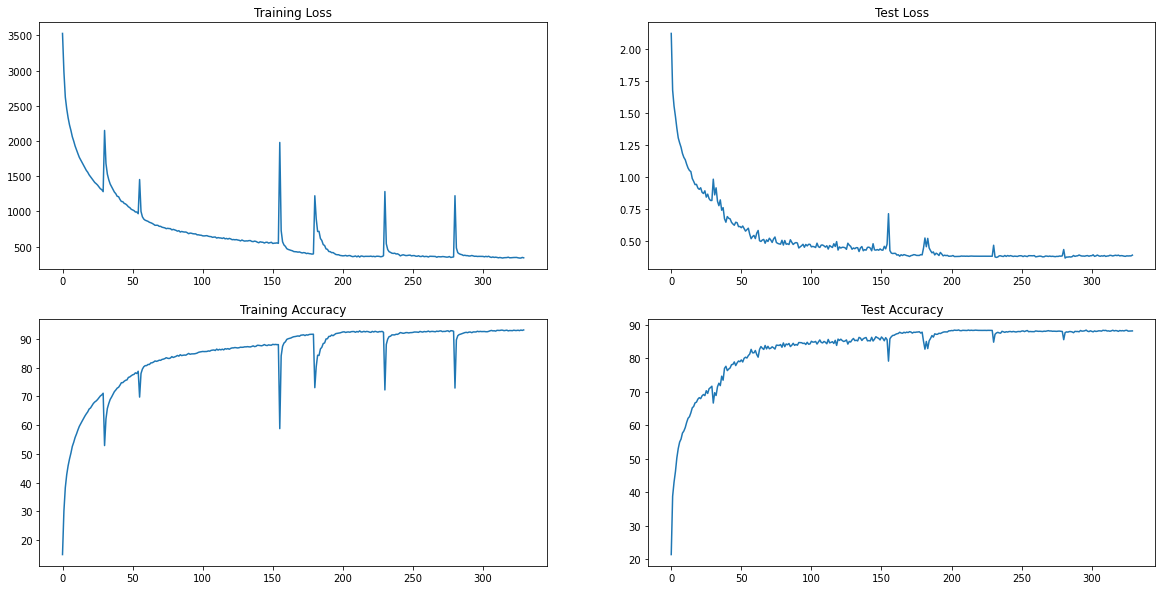

In [ ]:
plot_graphs(train_losses=train_losses, train_accuracy=train_accuracy,
            test_losses=test_losses,test_accuracy=test_accuracy)